# Media extraction

Our database is retrieved from Airtable, which has attachment files. However, the links provided to them (after downloading the database locally) expire after a few hours. Here is the process of extraction of the media files.

In [2]:
import pandas as pd
import requests
from PIL import Image
from io import BytesIO
import re
import os

os.environ["MKL_ENABLE_INSTRUCTIONS_WARNINGS"] = "0"

In [5]:
df = pd.read_csv("new_data.csv")
display(df.head())

,incident_id,report_id,thread,Validated By,Title,Tags,date_coded,url,source,file,...,hero,Needs External Review (Hero),villain,Needs External Review (Villain),plot,Needs External Review (Plot),moral,Needs External Review (Moral),comments_policy_narrative,Validated
0,74,2,NaN,NaN,NaN,NaN,2023-10-29,https://twitter.com/MikaelThalen/status/150412...,NaN,NaN,...,Ukrainian soldiers,NaN,Ukrainain soliders are dying in the war.,NaN,President Zelensky is calling for troops to st...,NaN,Zelenksy thinks Ukraine is losing the war so h...,NaN,NaN,NaN
1,75,3,NaN,NaN,NaN,NaN,2023-10-29,https://twitter.com/ThePatriotOasis/status/163...,NaN,NaN,...,The US military/ freedom for Ukraine and Taiwan,NaN,China and Russia,NaN,Increased tensions in Ukraine and Taiwan have ...,NaN,The opening of the draft is inevitable due to ...,NaN,NaN,NaN
2,76,4,NaN,NaN,NaN,NaN,2023-10-29,https://twitter.com/SabrinaHalper/status/17136...,NaN,NaN,...,Warren Buffet,NaN,Economic inequality,NaN,Warren Buffet is wanting to give away some of ...,NaN,Warren Buffet thinks giving his money away to ...,NaN,NaN,NaN
3,70,5,NaN,NaN,NaN,NaN,2023-10-23,https://twitter.com/MechaOrvo/status/171479783...,NaN,NaN,...,Trump for denouncing Israel,NaN,Israel and US,NaN,Trump is denouncing the actions of Israel.,NaN,Trump is standing up for Palestine.,NaN,Images could be interpreted as Macron being th...,NaN
4,77,6,NaN,NaN,NaN,NaN,2023-10-29,https://twitter.com/NotPoliticians/status/1714...,NaN,NaN,...,AI regulations,NaN,Lack of regulations,NaN,AI is being used to create pThe current lack o...,NaN,AI is being used to create political ads that ...,NaN,NaN,NaN


In [6]:
media_rows = df[df['file'].notna()]
print("Number of rows with media:", media_rows.shape[0])
print("Proportion with media:", media_rows.shape[0]/len(df))

Number of rows with media: 928
Proportion with media: 0.9508196721311475


# Extracting images

Total number of images: 637
Extracted URL: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/tK2q2Odj5UJJjNPuz-t8LQ/JmWVTLxZFt36o4bQWu5CLhvSmlP-rUv5IJeQwbVo9nNEZCe-igsPheUiy53XY_lm591VB3Tx83vepdznXxiP0eyz7FnCsrZXJv1e7gchkpRuWv1Ah7VJcoBTkTYiucx7mVzW0VmvDqricyPGXaBsUCRgWkxot_xgFu5D3z3_4FY/AE__vRRyTr-yW3xDRrlf9dAhog9XRlVDp6GnIWNOSZs


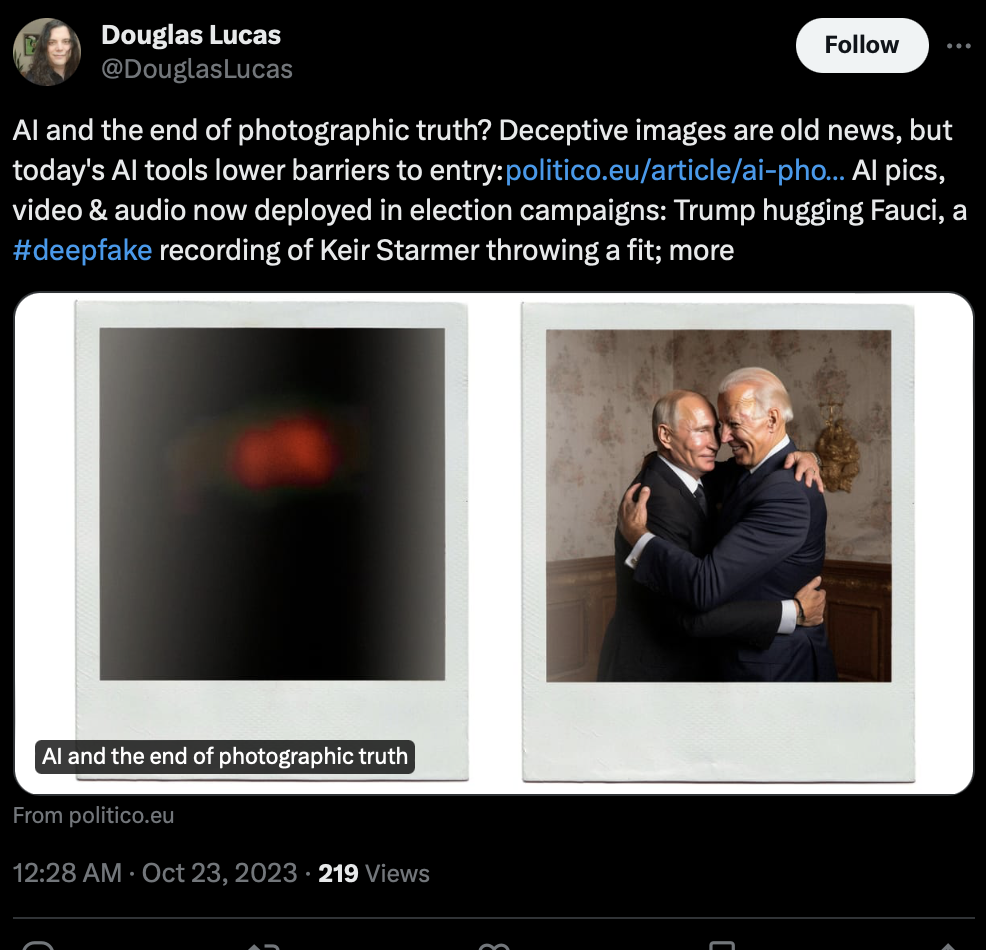

In [9]:
image_df = media_rows.loc[media_rows["format"] == "image"]
print("Total number of images:", len(image_df))

# Showing the first image
from IPython.display import display

image_entry = image_df.iloc[0]["file"]
url_match = re.search(r'\((https?://[^\)]+)\)', image_entry)
if url_match:
    image_url = url_match.group(1)
    print(f"Extracted URL: {image_url}")

    # Fetch the image from the URL
    response = requests.get(image_url, stream=True)
    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        display(img)
    else:
        print(f"Failed to download image, status code: {response.status_code}")
else:
    print("No valid URL found in the entry.")

In [14]:
os.makedirs("images", exist_ok=True)
errors = []

for idx, row in image_df.iterrows():
    image_entry = row["file"]
    incident_id = row["incident_id"]
    
    # Extract all URLs using regex (handling multiple URLs)
    url_matches = re.findall(r'\((https?://[^\)]+)\)', image_entry)
    
    if url_matches:
        for i, image_url in enumerate(url_matches, start=1):
            print(f"Downloading: {image_url}")

            try:
                response = requests.get(image_url, stream=True)
                if response.status_code == 200:
                    img = Image.open(BytesIO(response.content))

                    ext = img.format.lower() if img.format else "jpg"

                    # Construct filename with suffix for multiple images
                    suffix = f"_{i}" if len(url_matches) > 1 else ""  # Only add suffix if multiple files
                    filename = f"images/{incident_id}{suffix}.{ext}"

                    img.save(filename)
                    print(f"Saved: {filename}")
                else:
                    print(f"Failed to download {image_url}, status code: {response.status_code}")
            except Exception as e:
                print(f"Error processing {image_url}: {e}")
                errors.append((incident_id, image_url))
    else:
        print(f"No valid URL found for row {idx}")

# Print errors at the end
if errors:
    print("\nErrors encountered for these images:")
    for incident, url in errors:
        print(f"Incident {incident}: {url}")

Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/tK2q2Odj5UJJjNPuz-t8LQ/JmWVTLxZFt36o4bQWu5CLhvSmlP-rUv5IJeQwbVo9nNEZCe-igsPheUiy53XY_lm591VB3Tx83vepdznXxiP0eyz7FnCsrZXJv1e7gchkpRuWv1Ah7VJcoBTkTYiucx7mVzW0VmvDqricyPGXaBsUCRgWkxot_xgFu5D3z3_4FY/AE__vRRyTr-yW3xDRrlf9dAhog9XRlVDp6GnIWNOSZs
Saved: images/203.png
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/yyOdIUBY7Vos3dISBr7O3g/NYA2McA-4RKEJGaxLwW-C6yJkutqOxmoozPN5x90gZ1elsE90cw2LuGY9aj7spcQLD4hLckKuodqfM2sgwZGikd7aQpUnh5owk7rJ2WWR1SIPcdeU-tKAkA57SJvGIgQOx1LOTviZl4XiyHwk8FUEy1EoaoXmkGrSJPP3lfpCmo/9aVSZ27TwcnjTzIdAcskb8b9EwQgN4kfCjO4cla2yCo
Saved: images/263.png
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8qrXH9VBSMlmdcpOaOZdgQ/lhss0nJP1VcQBjt4hnDRa1oLnGYu1DcPE7Dyua3uazzx06jLp93WLlGf6SZntIlcpSwpxEhaC1k9r9EbLu7V4Me0sDrNwY6qdnapniu10rcbCu-k_MiAoQXoB-OBUOJDTXshZAwIXto9RrkjtOxosQ/IfP5Ik7K6nOCXDCC7sTApWDQDnapNzibG0WE-iW2PJs
Error processing https://v5.airtableuserc

# Extracting videos

In [32]:
from IPython.display import HTML

video_df = media_rows.loc[media_rows["format"] == "video"]
print("Total number of videos:", len(video_df))

valid_video_url = None

for index, row in video_df.iterrows():
    video_entry = row["file"]
    
    # Extract the direct video URL using regex
    url_match = re.search(r'\((https?://[^\)]+)\)', video_entry)

    if url_match:
        video_url = url_match.group(1)
        print(f"Checking URL: {video_url}")

        # Ensure the link is not an HTML page
        try:
            response = requests.head(video_url, allow_redirects=True, timeout=5)  # Send HEAD request
            content_type = response.headers.get('Content-Type', '')

            if 'video' in content_type:  # Ensures it's a video MIME type
                valid_video_url = video_url
                break  # Stop searching after the first valid video is found
            else:
                print(f"Skipping non-video URL (content type: {content_type}): {video_url}")

        except requests.RequestException as e:
            print(f"Error checking URL {video_url}: {e}")

# If a valid video URL is found, display it in Jupyter Notebook
if valid_video_url:
    print(f"Valid video URL found: {valid_video_url}")
    
    # Display video inline in Jupyter Notebook
    display(HTML(f"""
        <video width="600" controls>
            <source src="{valid_video_url}" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    """))

else:
    print("No valid video found in the dataset.")

Total number of videos: 291
Checking URL: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/fs-pcOumwzcQYxGV-BDnUw/0z_U2vCCfVcg_kyPXSbvGC3MXJOsa-xPlbvZHIKDAvfhGGLNmwfFzwjZQ1-vZLnT2_PfRQqgsLKhT2YqD7ikvLzwtxsBX2f_yBbMqUR5ZOEtiSLhKpLQvn7jpBmIClLFD1cGKQpKn-Gru4IllEGQW5U_ESKHYcaStpUUptf3xSCqJixWUs12qAX4GdoiVHs9N6oC-WjHljTYO8CwCcpZyYrfetJKaxtOgdOCzUepRFHyLbnAS5e_Kwu-ANwipX79W18E_QgvCdZzxZs93j-jeg/b2vaTH6bY918OJfwwrzY0gM6TIpoYhY62q_TpfDzJE8
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/fs-pcOumwzcQYxGV-BDnUw/0z_U2vCCfVcg_kyPXSbvGC3MXJOsa-xPlbvZHIKDAvfhGGLNmwfFzwjZQ1-vZLnT2_PfRQqgsLKhT2YqD7ikvLzwtxsBX2f_yBbMqUR5ZOEtiSLhKpLQvn7jpBmIClLFD1cGKQpKn-Gru4IllEGQW5U_ESKHYcaStpUUptf3xSCqJixWUs12qAX4GdoiVHs9N6oC-WjHljTYO8CwCcpZyYrfetJKaxtOgdOCzUepRFHyLbnAS5e_Kwu-ANwipX79W18E_QgvCdZzxZs93j-jeg/b2vaTH6bY918OJfwwrzY0gM6TIpoYhY62q_TpfDzJE8
Checking URL: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/HMHr3lGgG1UosRTeWrAA9g

In [33]:
from tqdm import tqdm

os.makedirs("videos", exist_ok=True)
errors = []

for idx, row in tqdm(video_df.iterrows(), total=len(video_df), desc="Processing Videos"):
    video_entry = row["file"]
    incident_id = row["incident_id"]
    
    # Extract all video URLs using regex (handling multiple URLs)
    url_matches = re.findall(r'\((https?://[^\)]+)\)', video_entry)
    
    valid_video_urls = []
    
    # Check if each URL is a valid video
    for video_url in url_matches:
        try:
            response = requests.head(video_url, allow_redirects=True, timeout=5)  # Send HEAD request
            content_type = response.headers.get('Content-Type', '')

            if 'video' in content_type:  # Ensures it's a video MIME type
                valid_video_urls.append(video_url)
            else:
                print(f"Skipping non-video URL (content type: {content_type}): {video_url}")

        except requests.RequestException as e:
            print(f"Error checking URL {video_url}: {e}")
    
    # Download valid video files
    for i, video_url in enumerate(valid_video_urls, start=1):
        print(f"Downloading: {video_url}")

        try:
            response = requests.get(video_url, stream=True)
            if response.status_code == 200:
                ext = "mp4"  # Default extension for videos
                
                # Construct filename with suffix for multiple videos
                suffix = f"_{i}" if len(valid_video_urls) > 1 else ""  # Only add suffix if multiple files
                filename = f"videos/{incident_id}{suffix}.{ext}"

                # Save video file
                with open(filename, "wb") as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)

                print(f"Saved: {filename}")
            else:
                print(f"Failed to download {video_url}, status code: {response.status_code}")
                errors.append((incident_id, video_url))
        except Exception as e:
            print(f"Error processing {video_url}: {e}")
            errors.append((incident_id, video_url))

# Print errors at the end
if errors:
    print("\nErrors encountered for these videos:")
    for incident, url in errors:
        print(f"Incident {incident}: {url}")

Processing Videos:   1%|          | 3/291 [00:00<00:23, 12.38it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/fs-pcOumwzcQYxGV-BDnUw/0z_U2vCCfVcg_kyPXSbvGC3MXJOsa-xPlbvZHIKDAvfhGGLNmwfFzwjZQ1-vZLnT2_PfRQqgsLKhT2YqD7ikvLzwtxsBX2f_yBbMqUR5ZOEtiSLhKpLQvn7jpBmIClLFD1cGKQpKn-Gru4IllEGQW5U_ESKHYcaStpUUptf3xSCqJixWUs12qAX4GdoiVHs9N6oC-WjHljTYO8CwCcpZyYrfetJKaxtOgdOCzUepRFHyLbnAS5e_Kwu-ANwipX79W18E_QgvCdZzxZs93j-jeg/b2vaTH6bY918OJfwwrzY0gM6TIpoYhY62q_TpfDzJE8
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/HMHr3lGgG1UosRTeWrAA9g/MX3F68KHdDtGumrdOqXLCSoHoR81o5xjLpwcNC9wfKEno4g5opq_ns5ikdCLT5MsvLtniHUgnASWZUHxDEUTjaqGa35bfXXzKQZn2vGaMWPFP41l7tR8O6z1prONIPI2tJBVCJSYEKzQKWNdWWQ8FQ/IkOOl2iXYbH7V7TEeNmHZTvbEIVksBlY-lS_BtwK6gs
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/corDVbz0xvJL_okqGCoXtQ/B_1QKs27o4pFZ9b81QUnMVat2JXa6CAuHbR5XrSJeCJqCb7LFO0cWmQSWHw9fkgD_5_trGK3QfY4YHckilU

Processing Videos:   2%|▏         | 5/291 [00:00<00:22, 12.66it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/rl6mC3tNR1QpfyRNWFAcrA/rRQZPqBoZtK8Zx22alOFSxbdSKa8vFjoaCGACo-TTpYhjjRM6wuHUP2TCZK71iv6Ky4Hncugwe14TVS9Ai6YMcw1AriOYzMCro-HPVFBKFRZiO9FdOd_E_39wyNohxQili5kBhQp1cK0RG5TLvhjiw/ulbFJ_EMagQpkkHIRGQorxL1E0m5nkWwom2fAaOgbb0
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/eVJamB6iCjhBNsAepJkXRQ/pJORf0nDydBcp2xn_WPKhJRONMcfLL6ZkiQRDz7MTLXy9Q3cCM4_bpkdjds8rbdfCnMOtwY0Cx8whkvwejGFmIdDym13eiuivumcM37h6tNdy7iu4HXA2YXKY9oG1V24TDee4nyZcS443EHBrbgQIg/6kGq20XBcWmrUYrVjBtocBnD6Cxf6StDPUis3xDmmRg
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/bg6RbZbKjWv8l_E8UwBBhA/axleeDQTuCcwobfDsjw2hBLdRif3WUTV56qwVxYDJX-ERIovIwxEnCrZg1Vk4qF4PWrnU3AXj9Y0blcec7fWVbXRZxEIc1bGcUsfT5xEQ72jFSeDUEhyeHvZLHbpuYC7ynWvR2xTjpwO36PVRauKeQ/8I_T__k7a2LJJJlzZlXgtkzDDJf260fQbB4mdmSSfjY


Processing Videos:   3%|▎         | 9/291 [00:00<00:22, 12.73it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/vt43WwKiaQoaTuRDpMMh0Q/sIXqPmB5tNBSDchSZGza1OKrhH9FuFioSdHu3cOZNR2ndATktsVgnaC2ziwEaH3Usq_J5tGhhPOy4ZFTWWD8dPepJhUHAXwDtqK7fPWZD-im-lxxGjoxiCOlsoVlMOb-xpFzlLChz_l6HheLjvF3Qw/XQihXF9MGsqVvoupYy0T6QElkOCgPjowsWQ-CIDz9Ao
Skipping non-video URL (content type: image/png): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/4vOj7L4E2nPcTOD71nG8OA/w7BQXpiYgBIM8FerujGPysnk8l55WUKU7UaUBU3WKqQPLqe4SOW6LPFClrUEZpttWWjG8NTcXBqc-q-bJKs5sLgX0gcbWiJYqmewRexW3LG9roqB6iXmEaWbqk8pcT1p_WACafTdWs1X3_HEP0fhVRp42CeT50C_WB-yI1Er18U/nMvRw9JSdzfVdKxu5PgQhkXBKOqcHwVrJIy3iLVd6As
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Qoom5o8D6izIntfvljgz4w/_UdBY7jlQzrP-BmJoOtz-IspPqIJa3BKQ4oHLBBmhKv0ApTjzxgzUbVt4xZZbqoDB95_LrK08TEe1k190TpMBfHHZeygwALg52em4A_vmvSYqlO9j0fNulQgyeLz1W3ypSAy3CGeAVAExzERYzn1CQ/4sqwd_ZlgSgyxE6izbl4E24YYjnH6a7qMBXN2Ah

Processing Videos:   4%|▍         | 11/291 [00:00<00:23, 12.06it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/_IjTjDD1lFZJzEVSM05d3g/QmA4ddUk_xCXQUjiAQE-z2eYEEbPsEqQuVGfdrwf_nnbtXrdwWuaQSwJe41Km0I11ztMhxMnZd9u0ltYpFBNls5TpZ-BncuYqfh5zJg7tNfovOMm6W3q7dc6JqON5yavzyzTgmjrIcHilQHa6ArGCA/E2CKEcYMl2hgjKbsNm0NkEpvghQ8s07ePeSQsAacHj0
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/4fAjJ-2vXNzlG_5XwRim6A/nTvUFkR7kbUA93D-hJ-Tpwju_RrOlSKTXhVP8W048f9zhBIWGZVTPyDzuMrIYx4mAxnzThfJ7EU5HG5dcioIxkEjTNaOgllg-S3W8UUQJpJFAmBXSA8t-3uWZDIv68DmOLGvxZ4J8r8t8xw9W9uBnw/2JkRxCfUNlngUq2nqBYC_Cx6rlXJUoC_H2M9xCVn2VM
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ytiKoyE0t8B7Aibl4jLYig/eScAfFwjsJvt8CWSSNUUsFC8NqKmxK-LwyeRzquJOUbEXHooRVdY685ev1Vw4AmGP9NSlPEnPmTpLJNk3HzcWxjYBi05zGbJfQOEHnVEwEGo4LswuXknlqQ4-nBfoGTIo2NbwB2Okf4vu7KiQGH6XA/bjQMHE_10pRywSmD1HvUJZBoUzSOsQTPpvz99-VSQU0


Processing Videos:   5%|▌         | 15/291 [00:01<00:20, 13.23it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/_-8yeZldUbv7GhDnKdgXxQ/9gu-4ffSqX2lILRd6r52qnqlI126zO4wDL2wWy97WrAmEaN-8gHoo0PDflChFBieLr8Zn3UnjaAWabD4q-72qQErizGjTKEJ7M42EHAGJIo__0-5Z-8T18BNnoO-AeE1AR7l9JAFmzRAZwoZyKOgGw/N6SfQUHsm8dp6yj2Ko5KFLMEAUy5vTJe-B8HoXw9AXk
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/SreBQFj67LwGqbdS_IBXug/nzdTc743WJTBOqjIA-O98Q5WzXTWCajGF-ngQD5Khph8t-W6N4dr4m2RKvtuTR9IKdOOcgCDw1MjnWc7-H79EL1wQdfUpPZJo7IqI-hZQvlJTfdXmArJ1qyxv2nI66YW8QpXHCFW6-xsSSW4TMVhog/cpiZLGB6rJuDw0dg5j_GOxnCfRBnzmmsj1f4-7S__qQ
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/l8q-Q-eQkimo4NqAkOr0UA/hAExYlIevaTylkbLh1pmGRPICp6tcj7pi8tGvrA5arEWMR9WyxRfBrwWUUIz4GLFXm_5QF3-jKNxN4OZK4Gz0vV9DpIGSTUcEI0KSBo7PQBbeAXgrXVnDua8mCdOdEzpw1x663xJoauetI9xr0Aflw/qLPg4rhSvzq904QRm24dKxkkUd-cZFxmS62C6h_WNoI
Downloading: htt

Processing Videos:   6%|▌         | 17/291 [00:01<00:39,  6.87it/s]

Skipping non-video URL (content type: text/html; charset=utf-8): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/CuM5wK2MGurP56-GrwQJ6g/y9Mmvf_3TnhfxWvIdiA5C2lIj1gv4q_ru7gAMWuPTG3M8PhTUULvXiQPBdDNiR-mCcrB6Pwo7z-xZPwB2QUt1U2k1jIcspSgYsQYBaT8M6vVAL2BioJfnM24UZ-2Tlhs3nl3ZsLyyXyAF9sMKMgKfg/3R228PdkEzUs8XNArqU9leD5pG5dsrwpLHGytxGhIbg


Processing Videos:   7%|▋         | 19/291 [00:02<00:53,  5.06it/s]

Skipping non-video URL (content type: text/html; charset=utf-8): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/hjgQskwExW4_jIaB20elVA/0rW8Ir9uCiGXTc7BmVaInw2dRWKzFU9F4FtYYBqz8YJarp8X30ITgzC72jBre8MPJ3OEsdXRRHvjdDNB99Lxs70OeSF36pxyCiGmKS14du7PHee7L_TE4pF1ztpv_yTf_C1ttB0ddfRU4kjjZdSS7g/TI7HCuAnhrZ0J9-vOjIQZAzU43UrN4SIfcK5FnQfBU4
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/yH4KUSlS57Q7UWJX6hQcUA/obtZUgtdbKiXY8riBRCUOq7MqKzxIdICagvC24bt5DDU4hk7a9N0OsI84W_m6rpnJYfQH3GjA12aKWVb5BUVz-Mo-gF90ZYcrnAGMmLD55gj5nEvfa3oCtDhnJ7evEj9dUAVNuTeUmSA9F7Mad9NCA/9IeTar0hS3yeQty3ZGHjbb4yGjD4Aq_pB9meowqEFPI


Processing Videos:   7%|▋         | 20/291 [00:02<01:06,  4.06it/s]

Skipping non-video URL (content type: text/html; charset=utf-8): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/2NgBPndmDhqSBJ6YLsN3kw/8jkqEgvLS1zg48afDU6mIDsXxAiVbgY_Kf1v84xYBUZV-tmUIrbd3ztIeEeUt72bz7de9QexIdR1ttK9LRcyIyTO_V0R1JQpjBaMRQVrfbGZyB9mcgzazDCfsK6ezUSMeV7by5xIB4EIgHw9_MGWKg/yTaCgXt7czc2KtFAcTzJxc3Ap2YPhrGA2oiM3Egu6EQ
Skipping non-video URL (content type: text/html; charset=utf-8): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/BPwAERDhldHgXPKVyB23fg/oDJnCLLXRl4G2ujaIfT2yUtpU2OTmynMDhL2ufB8iiO9RIewOuNEKs3QhBvi9d8H6ACaT1s8EWV2SQaGf0t184EEKDrJz1i9zYANMStcDWSBUO8qcl1xAwXCPIzrlw4S6gTZiDj79f2v5TiFGFJ3-g/NI7FjOaLhfqLT7_7P-x-AlgTM1fHOxwUaLaqwjABk6Y


Processing Videos:   8%|▊         | 22/291 [00:03<01:06,  4.06it/s]

Skipping non-video URL (content type: image/png): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/KJ3B5UmI9o_1djF2KeRA_g/KX-efJOJyaCXJ6ObpKETY2lCCmBfYdHHujMdoo-kX6U-Rx9E26ycxiSBsLsUgYsgrPIk5YwYm87hL39GCuQg-QwBUHBWp8wqbi112EEEQKXjWUvbDgV0pn3pAAzdCs9NArd_RZquLVe5WCujOZyHC89EqJ7nXGdz01rmpr1fDeI/A6d2MLdzWQUsqc5NCzfwcWkOlBGjZAPSmDCqA29IFB8


Processing Videos:   8%|▊         | 23/291 [00:03<01:13,  3.67it/s]

Skipping non-video URL (content type: image/png): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/R8-67d_ihJMVtRUl9TEnoQ/ckeYsnMfQ7G64E1HtJ6ku2Uxek_tVdGeXqrxc4yfoOdcYJ-_9uGpc4tlWlKR8deoCyn5o49SFS-6QG_dzEgN0HntoXVFPeWGxSdyjIWEQtBE-g6-RQE6X3QPMA4S5E3VjOhY7B_PmoLQDEMOp0n-7tZTtf89a0bv-PJEkAEjNAk/5w25Jyf0N2WMtxE5CjIRp6R3h-cGXeC2M4SWihwYSGs


Processing Videos:   8%|▊         | 24/291 [00:04<01:18,  3.40it/s]

Skipping non-video URL (content type: image/png): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/FxZKDfImWv85bxjTVoAOow/R8YCMkvy6hPKxpMrn1o_QKHlwJ8HD-k0jmQP8LEHemJf22rZHuhuQdTdP9ok5NVCXnnogUJnQT7ylTh8p3CiE_P_w9PRUjf8t4tPqj6XFvkmCfkD3SzP7L1HkZsZB1k7PwCL4rBuQIfaMzCMcdjYrd93imOyg22HI4Y5CGXZj2g/Htkj4_wRwdbCTR5IP7XD7118fzvkyVHJbIRrRLZiMtA


Processing Videos:   9%|▉         | 26/291 [00:04<01:14,  3.54it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/0QJoveytG37BWSxCkpUdjA/9wvOO9DjYSE_p4ZDol_3rDvIvC_YGUZlQU3iuH29Ij9UuXRm-fsoHkzjj4d5nju5fSUPBbDBP5nGD4BGexQd2BFDX8Y9SWQ0aRBOrJ6AQY3NgYo4Xq83rws51KP0Ipz5-QNr2dNQfWNiugbqNUTvSw/oi6T7f9nMWnK71yWONx732OiAU2_rK7eDBPqsnaginM
Skipping non-video URL (content type: image/png): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/fIpGnrzOwh8q0Fpn5Uz2Rw/w4Ff1iuezML4v0Xgc-I1KhUTU3RKlaUNXAA8nzjUdD6hOBj_iI_EEIKUU5OLStzTx_CxqD7QFgTyxRelLp1pzSsqj3ZsMX8OhmCYeZ7eYnKKcP87HAdxkaERb1vSJe2-s5K0OZKTMU0epuTQDE2oz7RGlY7Uqts4xEQQvnAcoRM/8N-AFFqWGBd5q8ls6g7GzRt97_N3f4Hi7JM-yCtWlIc


Processing Videos:  10%|▉         | 28/291 [00:05<01:11,  3.67it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/XIoUr4mlsgufEfqglwwxIg/aR_76z229GyR55GgGSTAVVgmKRqGyApOmSE-AKiww0g1dbl2tfE68zRUr360eNFnS8Kd_mE4QZjXAEEgag4n5idMsUBe0yHpUvlWgQyEux7rmxCu0JckfUp_0kgMptigTAEWHQjjg7OrseXyVOPK8ffx1ZWw6VZtrq63rubfkNXRbfl8AqafdLXwjhj8_3MtINVRsxAHnIQK31CTjz9ti4PZauWK13eD_WiyirZIrU4/suTiaAWJpK9WXHssifVohUgHPwaXAESRV3sn793pSSU
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/7kPS6vUE0MaVqlw5ArLd0A/dtu2qJHASRHSchxoG4F2dqJugGncYcegmnZvIEYm4M28fNUa0XXcXIAGfZIgAZlz7UZlnuPmSMCHGuTnyDQ6rXsdB2JX8QsXcPgT1zXWoI-ctxDhosQyCPief3dlqA0UKMD0JuCK8o1T0Zis0557Kw/jLdoXj8EOaLTVuNMzY8XzbFJkXpF7Vj89N0aZ2oSRGY
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/YcwZcRw-ovIm8M5aiXcXJA/WGMWmSxRntYQc5ZuC2gkqykeZX9LjsSDEPCkf1sJOoxw4dCC4n4qbe9b6vSg-UDoUsswIK7OgolVOi_8hb0225minMaL4RuxBtTzUqx4lSVU_wf_zjU-sHKdbXEQceyxtv9lx_QK6a6k9HnXbA-QgDijlOpH6FmE7p0

Processing Videos:  10%|▉         | 29/291 [00:06<02:32,  1.72it/s]

Saved: videos/216.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/PlS4GhGM5IlF7UW3q_Vb5A/b3Jn4NT2C1qHLRtlxgot4H8qvKOz8oewdivXhggtAcXPE2cWNzG4_laTHQ0OD3j3g_E6vuFzNQThtCsZSBmJnk_KrhVcY-4_yc9HXGq4KfKk4CAT7knOaZyNoJgk20qvaojBRuekNdbkroWAc2hY1-YGHMX9NMBdAro7KhnKsjU/X0G0gTmqQcv2pUXRfU4bfBiCJdAuTzLBLQdj04shqEE


Processing Videos:  10%|█         | 30/291 [00:07<03:24,  1.28it/s]

Saved: videos/205.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/VlkHTK6C5_fuG41CqdXCTQ/x2CoY1lR4kLU4W9YSlvO-FeGvzPWxm2jwqa_CQGMUP5laW8HAEudN9BQ8_4KemgglPgeTciP7uPzJ0lALUlCwvduv-8i2Z3CrCiibx_UwURMK7pOFVHBcNap0jVrAb3DHRczzfbNvfMMG30Jhu4iD5mGJw-Jh-RIZYgjAAfpwOI/1lDpy1LOUNWs1g745nTpqu9YjViMj15BDDDrZkbmY_w


Processing Videos:  11%|█         | 31/291 [00:09<04:32,  1.05s/it]

Saved: videos/210.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/6DpgMwgAYCembNCsKQyHAA/goRA5Gu6DOIMVKsvINZ3oauQCSJ9dNWNaPDt8SzZGuCYv6GLo9_AA1aODDkeYFZuHzANYTue-hyT8m4OnTrBUs8hZBbbOcLhZbyatF1tQE1PTlPhwJSwjgkWyfz_VRmNv66TKk0m0wp4pRB75DIsCA/y-Aw0H_JC_hOPE0IfJVsLhtYHulS5msRZHP_eFAjUD4


Processing Videos:  11%|█         | 32/291 [00:10<04:48,  1.11s/it]

Saved: videos/291.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/BRe_VJmLMldAhkX5qx5s-g/vcC3X63K9xY26We6Udq4cfcVsuMnVWnfzdljBSq-d-2Zl4sZkILlftFaL33zm1gdBaYII-FIkRuuAfXT6Bjh71gnrPSCVb4rCmKs7r5lqfJtBQkwfJ_Z1Hb847QkIJJUh__A7-uMDx-EoiAC47RNLaz73EtUmaT11y7tZdBT81U/9BsZmPwVXxnsFPU7S_fHPRAel6Mvoy3SZNCGTYhnnFQ


Processing Videos:  11%|█▏        | 33/291 [00:20<15:26,  3.59s/it]

Saved: videos/217.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/uqsFugVmi31jp8qOnMRrjA/OLKWvAMg3YxQFTC6alZ22WfdInDJhwPBYtW6jvtquXhCudfpMLKK5t_YtXTMtQEo9hTHRzr_JdNJkGScUaDECtgaT0cgh19ys0u_Pu42aeGodOw_rkkq_wX1Njk5C3d5LJ2aAecM-XzNH-9Sr3yL7A/rysRQOKxlAWY5cpAm0Tq2HkNg-_MeAU97E3xDkvLbbE


Processing Videos:  12%|█▏        | 34/291 [00:21<12:12,  2.85s/it]

Saved: videos/211.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/6Q0w5pouyxygs_kYsPn3Ew/AjUlHvqxqFSrUvzx-bVNW4ZLFJcUSqe9KSbys1JufNle-K_bOJ1NLvGwBNSF-gHeY2WgeHLf7RZxXXnA7c-sRkGBuWbcl5Zb8oFZ7wl1TqCWiNdmciUTcPiZeMTHMpxWH_yVK13oNa1xC7E3ZYUIXKoXxTi-aTUeZ_55hiiiTb0/iyObL2HqS2mEQ-D__LgD-eOaqULs7NWKaKsbV5w1HfU


Processing Videos:  12%|█▏        | 35/291 [00:23<10:33,  2.47s/it]

Saved: videos/403.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/mnjB_BTP58mtT7N8a5RyCQ/DtvN8dZ-1rnOcp2nXBdfj2tUjdhLn2mM67HIohf3_VShpz4SYoN9rzGRBg-FSeXpTVT83F5yqpuuWCLjQwoWSksfCVfS3x8e5Z4ZGZrHlLyQy7dykv06eL0Yb5fNZL1ZzkKdZQo-y5w3jDxqfBxhA3lJxyNwAqurfL5P81Ngxoo/Q89u1BFq5fbOXeJ0AgokOzp08b72VQuZJ7LSjFbugaA


Processing Videos:  12%|█▏        | 36/291 [00:25<10:45,  2.53s/it]

Saved: videos/218.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/XawzCvpPMZ9yFzwTQqYmYg/esHjbHeEHfdWKsBkiwsAbanW1FSpEUZjZO-DuCBvCpfE1XxmPC52dESqpPXCeo77jDlWcrJpBRo5NYIltYW3TcOstp3h52xtqwWLIzIi4FY5nE6Pp8QbeczaaAyidDylZwNbAiFFOCaI5nPFLOh0oIXDEyGNmVYDusdYv-djmNc/Wixk7_AtF6An0Zi4p5zm710OOx-ASsA4mRvW-afPU1g


Processing Videos:  13%|█▎        | 37/291 [00:26<08:58,  2.12s/it]

Saved: videos/402.mp4


Processing Videos:  13%|█▎        | 38/291 [00:27<07:00,  1.66s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/_ZHcz5h9h5Zyqo2rYN0prA/PkCoj6HFC2Snuwy4H8jsZIBJNCiZt49LtIS2yRkXaqMJSBel4f9zYzT0FPOe_taTe8z_RDEEixbc5raKV8eZoFoH8oLDkB-l9F_G1wz3BpplwsjQkyCqsiqhrPtuZswZhIQbSrNUrPKPgL6YEQl2VA/xMGF8_9-pMXl99ZD4966ZyVBX1UkDfvAX_8geVakXDQ


Processing Videos:  13%|█▎        | 39/291 [00:27<05:22,  1.28s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/yPOcHjUXtTYEmYwSILbqsg/hNGJjTpISVYaPNwsOscebwzYh6E6xQmc4YL07pcuEV76MjGzYwKy81xySnEghagsMCcn7QvJ1EpeYZEIbZLPaK9rlSKUS_yb0Oce0Yp7xCFwc2kqcPx_bDQ7cgj0i087NGupBJsoVFM0EcNHdmCPZw/vR1cQhIPfE_0JKzrGie6y-8y1Zn06aE851-zGdvdeGo
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/fBuijtNQqDHuFk2YPSDYoA/MwCDTW2_EU1CT7JpefDyV-HppTcDK8Cp8DWdgswrqwr43K3aQ06Tg2ULPqoOTyH5N-wCJHWILx8U4HOSOxmD0SkwQyLT4iYAmJBppo28Dlo-NKSr19DFn_ollAZROEekO7S4YWh2B22tS0oxOcV2hw/88tC3JIshmR_b7FVlHWOezL17R0iObjNc6sU_-wsJ7g


Processing Videos:  14%|█▍        | 41/291 [00:28<03:20,  1.25it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8SBiEhAH5Y_xC3YFQEVB8Q/3Pf2_AVKnwMH15dda9wQQYlFK3CAVv767TCqlikvDTQ3VeJWmow6zvHtMz_mSnr-zOj3j_bC8whMNRf4-CvJz9iK39gme8cf4cYrcYi2vDa7PK2FxIXaqrZE8KHK8oDotD_MkTkjLkm8tayNyDSyow/JT3YcaIURk7f1WmYeabY6TD8I1zBwZg19kxGLqUbmUk


Processing Videos:  14%|█▍        | 42/291 [00:28<02:50,  1.46it/s]

Skipping non-video URL (content type: image/png): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ZZqxd_iSbxsol3a8idWqFA/yAaoWgUrVZEfwILnxMycfMtFGZSfzkLn9B45hy6E7uGFgXoV3H-2qHaaoCkhgy86ZVkMfre2nHCGU5YiBT_9YXjW37YzSmnBF5MV54g9EMUJ5-TjRLAIRlVWwnsZUQvQ3txIRjSRYvsHNY2Yn9diicTfc1-khi1j6DMgG5rOnGY/RJ0gR9bdB7WOUXn6439BPXvdrriI9znnT3GDxQOl1sU


Processing Videos:  15%|█▍        | 43/291 [00:29<02:28,  1.67it/s]

Skipping non-video URL (content type: image/png): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/u-BnPz9vwLyDRGY40Vfc5g/MMgCwTY9lpDjqq7ch0OdRtVtUAIt6xKv0P7PfF9MwRqaLxUGVCaZ42wujPW-wlRYdgJ5G7JyVy31FO3Xy-GtPZat8dizo7R2kZEP2kLhw3FM1yQ1tYtxNowHyqhu1IBnXi7EHSrWA_EqqCjCUL4mzmKSeM0BwblqHuplqgLFJFg/TPrLfGyn-61NTusA-mc2EuYzlVeOrbDovBoZxDZ9ywc


Processing Videos:  15%|█▌        | 44/291 [00:29<02:14,  1.83it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/d06938hEhasIeWgYTpcWIQ/IAwBxWOUWuLUhdzuor-KZ3z4wpBIv6kMa9ihi_L2bh1qNieHnGbvvgUamA57nv2QT9hbYxFXzgwn7QWPFD5bR0sAKgi8qR1jaCm2SYlOe-NLRDfTRx8liwlTDs6V03lEEms1XWACDHAgUDuRFkdSbg/dfCAMzVHU1nrRHaeW6uFiLYOuan2bKtknU9AyZiXGt0


Processing Videos:  16%|█▌        | 46/291 [00:30<01:37,  2.50it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ocu5EEEfSd6Nl2dVrNxL9g/hWwk2yUDRo3aOgLu2FEjhRJOWrSCn_euyX-yscYmNXIi-nl62WJ-Nmpum1byOs275ANCEYz_XxA4I-HGV-CBii9k71TKUD80bSQ7PXtN28Y1Maefj9pc3-909yEtpLMnXS3MUdSpBXehmAKY3JaaGw/_-26tAYH9w2r9GABMjHHUnCN4JplG9l3feGo5bcFV30
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/urHqmACDKLP9Q6eCXqGJ2g/113F_GXEjXTz9y3sJfHPOFJylQcwiT9IvgmUcUloXmBGtpN0MfzCEZAaKxIWmvLDIKab-thkqMWEZnXCAVZAFHXPVbJ7JgIvQTu4_0ZJMGSkGfxDej6gGj6-ZBFQfWePpVWH_j26Ad1cxHN6JAuZUw/Cky54i2E3DsEGSykWpktJZ0kVvyO-q2j6t1G1abiup8


Processing Videos:  16%|█▌        | 47/291 [00:30<01:42,  2.37it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/y5eIYSC-VYgRRAXUFOYqLw/PwGBCcQlD78CyXUbUbQXwcG9K-5ibQLv3hjxSjg7yEabDAqOe1VWMgApHYu_XWu_53cdXr6QAyp-oqKBnKPnRVSjlahJnt2ZpeHe6hWcrnrn2IJTXKNGXZv_QpJjolE89-NnORRN09jVclVaJznFOQ/rtLPhoh1uIB4UcGtVTqA63-86KntWxRsFTj8oDO7dgk


Processing Videos:  16%|█▋        | 48/291 [00:31<01:41,  2.40it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/FYjWT24qlP7vG2fpIrnHcA/T10UTGMm45veIPIFmTbAua0j9npAwpL-1v4lkPVuajQCTPTy6bPTTwLRhtBvBpEckh8KQQg6TmBXnlvuMTPIk7n0Ux4GsAe-Y40xgH41T8tX-LSPDFD7-cQ5o0hw0S9qscGc-ncz-bN86oEqedIrgg/N4sd041tnOTEcd3C6WK2YkbRuAaB_KzBG6WR0DAwfTM


Processing Videos:  17%|█▋        | 49/291 [00:31<01:40,  2.41it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/dkmgSX25Vn8T8K0o3v6GgQ/vNVg8Z77_Ssi9etgzAy-kPbbjZpf7mipydfsrKzroWtUIxe6PBYuUdJglK-m0IAQBn-1P4M8XGUD1ERQD4svUBbt8EXnJvfJEZxyZrMhUq2xas5QJHb1W8X35zGGsMYm7cIp2OVNkCLI9KMrLj_JOw/1kyCojRj9GR8p5amFHeiLkiqKm1Ht1qtUKvFoQQM2v8


Processing Videos:  18%|█▊        | 51/291 [00:32<01:22,  2.92it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/i-L6lzAjqFzvWeuGkBfFfQ/qw5QOCmqtN-fvVX2le-lyNajwesher07KjJ3hHbsujvYoKkX_y4HD-FW6NUGjgpldJAqeZye4imYnuBIMVbdzq9qABP2vWVA2Fs73qtuv2c1mRZ9Ndg6c5z-uIw_M0sF4bVTV8ussWs3z7xgYUkDGQ/dzwZ1vO1Pik9gBZ9KXJRFdBGr9hRFD2z4bl8zh1J-4I
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/tiCck2aq62nyqfTilxzTfg/gwrj8nhMmT9OTPJ-yDdCJxA5FUEKlmJ-9kTM8OJjcPJLM0bHicob_hBD7NTvK1l7LOXlHPDyvKMiNT1lTUPELGb7_NiatCuXCjJuMJOhYY-m6cpUNLDNTI2W_w6DoefU_aRmjhKCOZ00vLJFvjhIag/CdJ43hJOu7Z3ZKUoKM1UhyN_-VQADzI4cnwVWPxD6RA


Processing Videos:  18%|█▊        | 52/291 [00:32<01:28,  2.70it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/lAUCuTCoI2IP0NJm29beQQ/FvntbUJFz0Mcurzg0OPmPMgSlcuAdEeReKBWhnSH2Vo8bSpI3vDhLR1RXGrgmxl5Dg5tnz7bfGmKbA_tl3syPQAxSEbgTptcfac_dtpi8MlxGOicR5rxmZDmbS40DpOYb88Cw9Uw4ilzDQKP4sQ-0g/W89tGrW_MdDiCK8mhqNNiDAlycbnYe2MELKWawZrPug


Processing Videos:  18%|█▊        | 53/291 [00:33<01:38,  2.42it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/6AuUWdzqjmpVcXiSjjQxow/crERB53Vvdy1wyGqFmcvtsug62SZSqCRW8tgmk14IFGm3dP-viAvDgxcJhuU1ge5KL_TCdJ3qGUFE-YFrjG9ZoQl7Q7_hA4li4RCDfr4XM0GM_W98En0FSfOkwpoY2UhiTddb-tBm0UyBcQKzlCAlQ/16NhZqeivyF6X5M9fjCvSYeCiC6ZtX8e9NWNZcIdo2I


Processing Videos:  19%|█▉        | 55/291 [00:33<01:19,  2.98it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/6hLMg_nmdVbZNON3KKB8Gg/N2VTowUIHj55BktRyjJS51DpGAScnWAlS_nhd2JPFtgvZVktwSiPNZB9mIajEhGpDRVQlUoKbk75FnzAP83DNpRKVnbnYGLDF5adXjsv85JRR918EaUnGxXw7OYnR-zeQCV5yMfGG8tk_NmLaCa-gg/T9tHGOIIqajvCgmiy84rUcThfu2HRrqxsmsILm781bE
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/YiPPShh2CDMb-KRTZHjJpw/yDUzwHOGRdw2OcOIg2bDFuSgzNK5vrPu296q5Jl8UPET6bGCy8rZ671Z2xwP_BNq3RtNspt-kQDmI-jmMh4w0RrsjVuqBjYIVzhA3Yfih9r-9qVt3al1Oze8z_S5wj-iTLeNVavbEx3OeewrmKkZ9Q/V2_tQxVyJ7t4hNg_u6TxgL3MOwoqkDkmby4UW3puGgc


Processing Videos:  19%|█▉        | 56/291 [00:33<01:07,  3.49it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/2LpQjRnUvs3qfCTzxMiGiA/VyfiY-nHEP56QyrBWmA7U4qH3Z4VQ5SuKavvlEW-BarQbXA53ARQlHxGinvSOImXOtU97qLy3Irh_czbeQaaxJci8qNwdd4nJeDDqE57rKpQqAXQsYOT9MqocG1FICecyixf2VJo6Dz6bChyKE8_Zw/gWQnEl6e8FTD5PY4hmgO24-jf-cQ0kHaulxp3n8W4E0


Processing Videos:  20%|█▉        | 57/291 [00:34<01:15,  3.10it/s]

Skipping non-video URL (content type: image/gif): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8tGM2HfYTpbvI40i0PAwzQ/tht4SkhWzJxVB2hlWyZ94tFXLXl8CfJyquLSJguaeIXn-entYkuwAEsh_jO2PqG53ErdvlhgYFzL620JYTs7_fZ8CwCmLhgEOftuN8NB6iRYAjbwT4awKYENWP4_rpua4xv_lQ4QJmTV_Ob1Z4pVmw/vHYTcIr_bFNoKQ1tWQHkwTgHD72iayRSUvdKXQzGACo
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/-cNEGlo-cDXGoH4OVw8Rqw/QoqTfZqTWNFzPh5_tEGwQU9S8B0ULAGzTuQAe_MbWioBRJdw6-cuc3FeSQtG8xb4eUXx0hU-B_q458HSc2CXr1CronwoWDIuvMu9-OAKD5YoTyHw1MxzNo8pFUABnH4fvV6kdRJU-nptpJI5QMNjZg/2scs0j2kkoREoQZ31K42Zwov4172eZRf8dKUQV3Ics4


Processing Videos:  20%|█▉        | 58/291 [00:35<02:02,  1.90it/s]

Saved: videos/221.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/IM_WJDZMD5cOhhXgGUXTDw/8Q4eKaN6rs6mv3wKeOQrFm7QuT3sU5z-vEAjBTNevqqvFD8PM3dAPoYJyS8H5tC-6DDvyVg16j0SMwBrhUfg8U4cKx-VTWt6VuMVlUwFiRI2QdJIZMIWdsOYrwE5uZgSHlKlr7ENp1zjhfLT8_3SQw/ixBRwj9lPxtNCAgHiRVi9WXPrc2oGVyd3Pczhy8_D8I


Processing Videos:  20%|██        | 59/291 [00:36<02:55,  1.32it/s]

Saved: videos/222.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/F9mmKVQf2s3Opxgymk2sHg/xI_bj7Fpt0wJ-6QoCCbgfSpOYA35j_FdWmC395NQL7fh7Msp6qDITY4voQx542ZKsqPyEknqHQ_Zeg-WPvOV8ZB857CjPJHHAzeYfiOC_NeJVvCALXhfu6l-1Qdw-_OLgs2ZF-dHzNWpfEULd6GLzQ/dAleZbc8hHuw4aRd8shjgu3RxdlVCX9ReONos5Q8BTo


Processing Videos:  21%|██        | 60/291 [00:37<03:40,  1.05it/s]

Saved: videos/223.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ZlEyCk1JR6nSgMNc9VC_-g/5iJQXB2swClB6BHhYxYq2P8RESiCRIVrzXKhp4VQqgHZJVujXLnfys9bvaq12YOYgLI4Kblqd8NJCDf8Z_rfyXdMqPT9LHfh8ON49qPGu_F9r2i2uO2IjIqjiJ_z-QzbAp95zZgpfWyu0M1gC0MDCA/ggoufZChesPb3f79oKR27CdC2Kgj1QSBwyzLtqZ7awA


Processing Videos:  21%|██        | 61/291 [00:39<04:00,  1.04s/it]

Saved: videos/224.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/7Gqd-W35rSq1ENhjcrzJCg/6TwyAHRSOBvc9o22DWL74qU1pbmv-AA9i6F_opQws8VWH0ouLpfGzOA7xwSYaAWBBesAB_PjjHEFPNnvoqDOIJAwS7LiSfDwmkY_7-GPj0L3eqjUpzzi5RYlvJhV7UDem7H5Gzxe75hGciKKx06SQw/tQkTvFA4dnwfY2MGDehwcIchJliTcCxRbBSXh6BOw18


Processing Videos:  21%|██▏       | 62/291 [00:40<04:15,  1.12s/it]

Saved: videos/225.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/jWdRWEirBlaIzSA01H-aEw/CXIhW_nhNO15AhA95gI75PZp4dN2Rz2GTJ14kuiAR54y1wBNJKTobxJDa4hylq6dhJbFEmKcT4Q5zyS4pswgCV7qbEB8v3q0rgvxetQ3R_7p92S-EroIGZq77baK-5OTly2noNqq8QVx8oFM8UTjiA/6cO1bRrOga2RjRcpiTv4UJY21xJ8IGPrNaV1Tc4GQ6Q


Processing Videos:  22%|██▏       | 63/291 [00:41<04:41,  1.23s/it]

Saved: videos/226.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/PHuvuWtQsdDPdlj1WMFQoA/ezFK2MxxhuMW5El4vIBYz3R6phIxcra_vmk4yKaPWTtT3Iql42ID8GPlGDYsA4fFsAJsojvdiQoE51Xvij9Gof4GVrC_yG5gookkp0cYmReTa9teXjLywG5_jkha634sUYi-OE6EI0AyDeAchsOwEw/fmtem-CgInPM0CniEBDTc6AcKNc5HMx_W824d_xfaBI


Processing Videos:  22%|██▏       | 64/291 [00:43<04:38,  1.22s/it]

Saved: videos/227.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Ggu9T0nbZMh-1olSu7oDpQ/wriad4cYDkERcyxaJu5Dm6mg8oVQk4DygHEEwMmpBvkT8Ic-sa3IvAlzBFHLY-Xpp9enXbuswakA0Sr0RqTQatu7jQIUekKmB7upmkrpR4rI7v94Aayb1a32C6xA_VLzRCzJu2kTnUQd4OoDi9JVpA/p_hsKIHEqGfRibY7rBNGaAsnrFCWbVCfCbUmWuMzyRo


Processing Videos:  22%|██▏       | 65/291 [00:44<04:48,  1.28s/it]

Saved: videos/228.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/R1z4AvwOPMfQtFxF7HJcpQ/fyvpLuS2n-hC-iOBkolqwoxVwKCUfv_ydT9l3eF2PHcglL5uqOKr7Bq1Y1m-Q0JKajrhhOXdkv07D1CZYHelq3iFYkxE6-bRk3FpjVXfCBPHHQ0x4lN9gft7Uzbt2W6Ge6CHVkioMlbMfHT31e42NA/iEOziKQ_fNZeKPtgyz6XkFklHvzu7Zq9eZq6WM626MM


Processing Videos:  23%|██▎       | 66/291 [00:45<04:36,  1.23s/it]

Saved: videos/229.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/52JYiWhe2rt9DQo22LMY8Q/EJHFL7wr-ZaH1hBim-BBLzjDqOz_g32ThDNE-E1yYrEstT87jyYqlSMqqf6WXrXW3g8mb3KQSf6Azij69hFNesx5yvBlXfKCm15yLXYRnus2xSsMR7aCjm-dv5_Eu8Fq1V2XD1NI3vXS24nxHdVS2w/ec_M9OmHmT0OIC-NfpKat-VNPMTGltITnkQBKbzIEKQ


Processing Videos:  23%|██▎       | 67/291 [00:46<04:27,  1.20s/it]

Saved: videos/230.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/MkaskHPJFqFfT3VBaMhVNg/cIkJucN_1WtlFRUmYE4gfu0nSqA68Qo3zbuZf2gwoR5ZusACtgAXrs7Z7tLhmkPJl8jRArPDjgZHnDH-ja3zTg2T8oxTvqFGFypuPxtsg1CQwTNaBOWhtQRAkzEL-Luyj-HX4US5lwMj4i71ngnyrg/gYCC-tfKKG6Fn32kUnUAZ6lg-mcFcj9r-lciHSb_Rgg


Processing Videos:  23%|██▎       | 68/291 [00:47<04:19,  1.16s/it]

Saved: videos/231.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/sThCvpyszTyX2PpQmlGgOw/8hCUf2uJZYiK8cfhb5VugeCN3p6U2ecjKYKLjGEPnp1gjmU4iw-uI0j0AHw1ruj32IcRa2fL_PTUBS2pf69dgLRYBFrvmaLWzDKWaKp_nd28upTVSiI2Rz5pza1gTkbX7xGGdA0tHgOXl-lLRDqu_3rIJrC4BdyKIWeWlT2VNmewse4WrrU1CMSQayJQhXwv/q-Ns-LsNwODJFqGOZL2LCn5KhDku0qSb4F-cNyhKVUg


Processing Videos:  24%|██▎       | 69/291 [00:48<04:08,  1.12s/it]

Saved: videos/232.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/P-BC7guV4S2o6HeJmOhmMA/XUBuZlhcLXPP4-YOdMHxCqH4aXnoTQe2L4wqtJ90zL6JMTrQiAGdlKSuIMxewWFuWpJN6ekNf9StFkPEcZz0_qlFedhINOfwI58ZtKX96_LmVRWSSuP8bu1L0r1EZc2RaaLt8adKtcxvajvDC_ESZQ/CFmRplv_NMT_P8r6FdLJ1JnVmrDcMw3rs4jAMHSt9do


Processing Videos:  24%|██▍       | 70/291 [00:50<04:22,  1.19s/it]

Saved: videos/233.mp4


Processing Videos:  24%|██▍       | 71/291 [00:50<03:31,  1.04it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/h-b8RG8CRdQ3j1vl0-LqGg/xGYEZ4TBlbwXQWVCoM6zZukVaffrdFusL31y2Nawepqly-5Wljh04XUGHeCoLUOG12ujMxjzghDw4rt36YRz0j21NsKdTQy4pH7uoLGvePLGUq4bAEPHseHWQOIvI5EjZ9L7RdhAGlSdR76eR7HtGw/9mY2tMXCdveYmjvMH6mxarnQsHYHRhPg3J5nSqbc-EU


Processing Videos:  25%|██▌       | 73/291 [00:51<02:11,  1.65it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/nNMlFvUnOmPR_Z4qSdqt9A/H7hLKdF-MoUpLPaq8Dnx7RoRTKxzCtSCBBfZFxyZaPrlaMcnwOFi1_QMBdr1FQzZEqjIqOgGrgTYAcvK-vOhESlTwl5n20g_m2JGnfc62njQdIKZLA4Aie4o6gGi5C2dllb70-I1W3jWCtFAAyNoaw/nndEmyL06uYwUM4rCeVoXeWaxJcxWhOBh_Ej0wB7bb0
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/zb_7wPNSbgs2h5mrp42zyA/TTWvy2pprT42JVPifem8lh3SYqrDl1X8sJZdsXl3I57Z5lu0Vq6cjB0SFcXAbCd8TrHrkdyI1DsMUB0lDwfsqnhaRVg-JuRznwD-4AJoK6Mx4gB-FgM42N2j2lRLnuuorf128Cnx_GlGBQD22svgdg/VFckxV-q1l5AFU32ymmsu1gLNTEi0tN19QIokuBT7uI


Processing Videos:  25%|██▌       | 74/291 [00:51<01:43,  2.10it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/pnOiKrkjiaKAR2m5XurVkQ/1QYCkWNjM4nBdWaDw_8iZMWHmpx0yxxiJp8mCHGaqAA4aJWc4Yy7FCFvXuwAmNX7-vaNXqTLToezvEc33COCu7OM_4sZq5FokU-kO_-iQDXSZ2SCxFiMOSUTWswvPl9dqApBbbdqEav_MBZfW4unnw/ma_hIs2mRc4bTRCA3nV8rPPV1lMiRooYSwJPBjJ5pf4


Processing Videos:  26%|██▌       | 75/291 [00:51<01:36,  2.23it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8jN2tuofWTGAZabK0ZdzsQ/fUq7wc-98FelCjHReH_iTYlNLIqAEUgazB8_9QXpP_lDqJDzKbIsHWp8IyogKiQ_7nLFtfzgTgRWEN8_uareIQ8kAhDRAji1MWtEcumUjOyUKbfi_orv-HIQqXs4zEEyGGMa3S6kL26I4JlbxtGLhw/_PF1lB9Lzgn8iuqXCb5te3T1llQc9Y0Jx048VZT75SY


Processing Videos:  26%|██▌       | 76/291 [00:52<01:32,  2.33it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/fQY3cFWBeDnDeZnZCktxxg/WIUsEMV8iAtGPYZ8P5LbbgXokw2eDO5CmB2lWgzVEfBeAJY3XROyjnbcwmoIXSL6pkCH9dk121pJYjKmDLK0Ielo3Swj83BbHHGb9fsFyawd2cIWUkN_7cYXb6k1WEeyhgJ15I-eFwTKGy5zUKwY2g/1gVLqo9xBDupAW8-hdjF0rXrrJMFGhVfSOQYZWFo2bs


Processing Videos:  26%|██▋       | 77/291 [00:52<01:32,  2.32it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/i1X2S9xLHNS_-YbdCI6vTA/A99tAyrOGYSjQb0Scc8rXDREeugGLgleT7hTzOJt-i8tnmuUuMG3Lf8zMHUhA6tLssi2qQmMnIQ2X-PBwuPYJAymUfX47G-mcRLeEfo2mI-owWKKwc-gmohH8djqSypFZ16vsa2KmpQJ-ZpAHij9Mw/6qBhbaxRK_B3TDjccnt477Bbwdv58xlmg0LzVchfWgM


Processing Videos:  27%|██▋       | 78/291 [00:53<01:30,  2.35it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/m50k7WY1hrxh8y1yLRsS2A/b9X_vDqymFR12hNPxIzUT_zgHJGKXED0gMIwu_Ap2_2XDXNgzpYlUgKGi-QUNLFSPXKJRciiC3HMOYMgbYIdws6rgKAszPUHjmbY1jOp4zbvKwibk0x1zTP8yuiYEZuCZS5BNxj8g6XsSdOwi5B8QA/VBoGCEdDtI90mMQbXQ_FzrQ1tYaVXlYz26MVNmu3Cc0


Processing Videos:  27%|██▋       | 79/291 [00:53<01:27,  2.42it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Juog0bhpqI_juOoeuEbDnQ/755uJ0B4C1Jn6t49Va-Q2EyAebW-imYCuvlcNIQ2a49Lr70nifFbaRFc37DvYE67Ke0b8FcY3zpSDbYF-a8W86RQCcEXuzUMdw7HFiPFCAbRN-toG6HvnLyIHfrGqAp92QmsCBHgCr12MoNns_X49w/EsxE4NfZICXwfzGoJb_-uCdApQ4xPp0xv4VLU8s2SPQ


Processing Videos:  27%|██▋       | 80/291 [00:53<01:28,  2.39it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/3wVsmqWmSslr8xD2N9f5Qw/q-UusyafUz7h1K9l-vC48z8ecicUoe28KYA7bEnkADRI6oeh4gQGllXrypP1HuWvoLueuHfLFuJR5U2H3RLWEBvdv-ModhsODiMtZlD3gkKUsYNlKS9EjdeyMPHagGBTCgKE8KPhO3bCjxljhbW7ew/zZIW3c_AM3PncuiI5ext7LyHPyjeX-S4RlcLrFVTRKU


Processing Videos:  28%|██▊       | 81/291 [00:54<01:25,  2.46it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/t8r3IH8DfvP0x-ulI44EUQ/gDcXmzbWH22s2zYcEkEl-SyDX0DfUq6rV9BXOb7jEF1NhVVmvtyhLUWjGWDKfZ9USBWRuRjR10_klAatjjgVNCyFVIuXV55YuPh_Mq_BbfP_Kv84FfpDn133IuPUgghbe2xCt9fC4uldZyAonlJp2Q/PO144WIxT8it3jbrKowqNmUYxXLZQK5Ne1c9yg6umhQ


Processing Videos:  28%|██▊       | 82/291 [00:54<01:23,  2.51it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Meu-iv_h4IoI70wg-8EdKw/9jan4rVgD1jIeurAy6mN93iLqDVtGkArX2kp6WxVCAVBhfWmM4ug0m6y2Kmfrf_n_tHtKn57cizTmdBrMEjmWYLJD3xUZTnhESBqfNinHWf_srD3F59JkHtg1is4iUt43s--pfuBNUixulXovQy9hg/sRcHQZxeahhEtI9CGacqVYDom4tzeTdYql1yO-sgNxY


Processing Videos:  29%|██▊       | 83/291 [00:55<01:28,  2.36it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/RcknBsYrnZO8VMx49dW9VA/gMlYZdsHZBktPtCAGvOhzppU1gl01LLfKS_wUDSK7qpd-OiFfrTRDUkVhhAK9q7hRM2JPLpwlHkenU4x5ZEGGpY6NqxoaFO4iG2FgxlWDeh_AfczKSyfjTCfuXG1CduZg2Hfdw0K0RFCiwE-YOQ0dw/8xbRsxLSmdlGVs0V5THSZdDksz3p62Gux-3ryA7TuyE
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/c7T-fjrsZsBSEnOnpttnUA/11A8aSoP03l394wTDc84xi6RuJNSrS_XT_Na1orgm4Kg6FEHji-_h92PXOSFXPKehMOEhkhWmfAWHSWb3ht1Nw8BD1xR8kalzKqmOdkuMOarG43cukjfaBwDI69nDLqKqWuJGZXXcg_F2XLn0Y2bn2284An58-zD9V4oNICnGX-CM3Jk7dDJZAbNCIekTpw4/kgK-cJJf7_TRZ3pxAVd3CcN8ltAK8pUvfQb0MMR5g78


Processing Videos:  29%|██▉       | 84/291 [00:56<02:10,  1.59it/s]

Saved: videos/234.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/EDle8wi0Xbtp1phMAC6sQA/e6EzKOya8xX8PKETN8bawswmldXnJuCJ8dJw6_xuBCy8-xz-MmZ8i1in_1Vpf0yFr5sW6SoeW1DUdggeugeW91JclstUXXOtsko4PTRSZLqrYYsH23q5pXTlJzlBpOPcqTr-4kUcYiP9kC4ytF-4jmLeJApGYRUaL72zMfJNJaexAepovPZEFeF0PGS0lnjK/VO2qiqTm7g00KOq51C1DbDyPjVK6mHY9ocC6Lcsx26o


Processing Videos:  29%|██▉       | 85/291 [00:57<02:35,  1.32it/s]

Saved: videos/235.mp4


Processing Videos:  30%|██▉       | 86/291 [00:57<02:13,  1.54it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/f1br-Io26bMdw_bdID37iA/lqjlUp5OaUsGH14TvUghFeOFeRnEaUvHuCIW89IL0xgBpD0761K85aTfCT9EaCwxUKAzLvKB1mVsmYFCvnvS3nPPavdIW0OnuRamssaDvk8oj_o8XJrjTgpUAxXmqx2HtIXFlhJaI3KRFG2-1YTp7w/AiU1EKQdVWdb9KrlG_2jrbvdjzqQSSrPKCD83vRJhHQ


Processing Videos:  30%|██▉       | 87/291 [00:58<01:57,  1.74it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/LdZeLPRCmf8TmoKDibNHyA/0u-BOUDJnljeWL9oq4Z69uhHlboRZJtlXJY_XDANVkO9OSYYzuU1uFgrzewjewVeFPlcIrdf42g-CNj6zF96LhE20ewY_0XnDBYC9ovfluxrTw0-MGsVETdPBvFVRG8kXUVP823Io-j1fxBzrOolGA/gqOHrJrX-xcz2sGXf7EiwX6Dvy9OcKHzmXVOGrlJTzg
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Tie3Zx778ltJtYH3EqtoRg/e-CKaPQ34sDKea2N7mdly6LRZuFmv1tzZFyxWpw1xjuO3ZEfhS0YrJso2XemdS_Mml1xnzxM05t4xfsxj6q0H0al9VMDT7HqRNQXbaQtIq5UaswBKCsACYM7xu8dlPGUDjwDR2I9QJV3Gg7HKqNqag/vycX71vJBPPz2yscjvg-c_zwLjW77THWBSt5M-aYUow


Processing Videos:  30%|███       | 88/291 [00:59<02:38,  1.28it/s]

Saved: videos/261.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/_HHjLKIcFyAHWI1JcV_tvg/-PG9V1BNZi9YJXFgI_Gbk3MEyVfV0PvtaIWQ7E2_IPURbDuYpGSrWFybWtkiXpbK9FPfy8SnQVfzjaEisxYpHIdG9jaLJUtGT6kFjgf0vnwHs8wS2EwCZKxH7WD5Q-ls3IRcvBkdsun2igSuiSULRg/oo9fHGMD2isYn7eX4bphfmggcBoA026jn5K6fhwpVCU


Processing Videos:  31%|███       | 89/291 [01:00<02:45,  1.22it/s]

Saved: videos/260.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Mq0NCh2qVk5yM07CyZzzng/eXwyV0r4DepUGYF0yesi-b3yGwOXMJB2W-reGjitRW6-zyhvmwPtwgKU-kxv0TdZHUcvgkeEz8tjqusm90-t75IOU8XGKQm8fjXp0rTnRsl_gFvXMGi6DZkP86Rdm9zIUag6Ik4_rrQ8t781qbpJP8x-XXst9u8hC79CIlPl2KpmrInGazwfyjpMqYQKwDnWRMg-ORpkrPaQTHh3LCCBCgHsCVZx_BV3teYi4QDyB8ecWNfuX0tZBRdfUMaGp0Cw/jhQ-IQE2LPbhI2qcqR5_KzJi1XTXmTrrbB7jxSrgtoU


Processing Videos:  31%|███       | 90/291 [01:01<03:02,  1.10it/s]

Saved: videos/262.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/_k597ZYH2B4RUJXansZGrQ/g5y9_K0Fb5Qi1QIPLXnX3LxWvI8d33X0bZghJArsOna5IVZ7lPXW_UKkaG-trxOkJosqkYhFMl04T-IvV-pMB_P72OmnvW32jofsU6mvEv6jxpiW4Sh5mrC27MFZ1s76Sy3hOadFKK_h0R67bDF0Qk_ZF0cmICHV9L0XGKN0iTc/3wgFBrur5UelAznb75qD91ZoAy3qUGy-f6Xtd-3YemY


Processing Videos:  31%|███▏      | 91/291 [01:21<21:53,  6.57s/it]

Saved: videos/281.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/06L-e_sjFnEr3RUf9d3ghg/NlpYv5oDrVVO2sVpCkAP5zvPw1Uvvk5rXoTvNjeVBseMevVkKsYq0_57w1d3g3sQ-W6G4Rq7YQd-9arO8uC5A27FZOhQ68KXQs4k47uCcDhnli4Hw8dUgggUj1l7Oe49PR3Xd9bhmH8TC9Kylzubh62miPPdgKEZlzVcBx4HHD4/croJrIpDghg2dHPS3NUUgyyp2JrdxuErulV1DoIeOS4


Processing Videos:  32%|███▏      | 92/291 [01:23<17:37,  5.31s/it]

Saved: videos/280.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Nl3KnajEw78ilT1srJ1YZg/ew7_efER0nFjYQAx_uOFXz39tapkBJ4Ca2x5Fm6Dq5vRMbarPUnwW7aWKTMF_fKvYVVVs-so4ppI4voAUYaufsil_cO5psRA4Q2Lkm5j3njlaSrdKDqvdIaXCSnbpvkRJmW5r7ilxqz4D_HhWOMEZU7Kse-maGyCsJlS9WXRlMU/s1jWkE-iRLlfEKVOGRtNS77bxeJinLW9ulW4go1WEeY


Processing Videos:  32%|███▏      | 93/291 [01:27<16:03,  4.87s/it]

Saved: videos/279.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/HXjwQKgfYImfYy-oQgLHpg/Rimsdbtx-Qz4XiPhi7ICeK9Nnv-gaU4SkC1OIWrHhpYiiYVPtJ_xW3PGl3a6YekN2YhYbamGM_S9bjRv-nhS4EToh2THGv5DeA8vOrLOYqRmBQxm-RCqx49XsuGTdP4kx6RYdXmIdsqvcRusJEa66HpwjwC6TU9KvOU-lVje2_U/D0o3DxwFE_idrTRXdQWCLb3l3Gj22f3TN9tKj6Em9HQ


Processing Videos:  32%|███▏      | 94/291 [01:32<16:40,  5.08s/it]

Saved: videos/278.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8JDf5YkFMGBLBcajaiv4jQ/9JnhqMk3NH37Rvo9x7MdbJ7ZgNLLRgL3wsF7oJyQv1XAJPgKPOYDXdOun1BRxq_5jrdaDM_JQTTsVHqKMvbt-5HpWHarqM8E1FYy3D5SYqVHcS3kwBkWQh307x2FjTeAPBsF_SExx0m6lxVeOOOF1yhxubmkPB61khlu8G8HbLM/GGRq3Yw0ooWX-KsGvRwGciTWj9EG4zabdh4u2nlltUI


Processing Videos:  33%|███▎      | 95/291 [01:34<13:06,  4.01s/it]

Saved: videos/277.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/nX3zo6i2xTMoQWVG_reZEA/SILyh-V6Ahs7jd3J3lKqgBwiz5V7wMXRo7-u-YJXlwZAe4ekfOkB5nz7GrJXj9GFwRg2sJa0J_gOmDHAo_TXzxjLbLqzHjSivBsQ-FtLvI9-CPpxsQT-gOLU0ypoCaWU0SHW2YwAu0Z1oX-ZJfuJfoOXuGaLbSSlX3-2YD3PElY/XM3ARawkG1gQwFJtBurvRC2hRh7XPSKSaGCd7Szjfi8


Processing Videos:  33%|███▎      | 96/291 [01:37<11:41,  3.60s/it]

Saved: videos/276.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8paDbxGx7X7lLUc2f-O0DA/1_iC-HYdgYzvD383xWiBge2Z9r6fGwWVskwhjuNWo6SAAij0iG97G-ixdovGOn9Ll2WrP13MPyGLPBTgR5HZs8j44Ocvv4-X_0kiJtnYRphJMh5N6GlSn0WYF71gVhHgUUTAv-t3RAx2F5hJaVodpn0PxeGV8IdMfF8DsHrjnEk/k5rUWH8VpposAf3wufVM9WO5l-SkEG17r9LqA8cdfgs


Processing Videos:  33%|███▎      | 97/291 [01:40<11:22,  3.52s/it]

Saved: videos/275.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/dWhak2VtqRy8U34TLuMQfg/5EOuTtfbTbPuKNdKBtWnAdO39VkmvI7yTH6yzie_n6u5F9gFuRGH6daH75C1pHRONJ0CZP4H0TjTxOlm1U1osKj4P8rCvrcnc_DHkWsSwP2Cpz9y70ZeCndh1dSkxWXtWHb7rUYVDJco4CkLdHK97_6hOun7tIEM6dPtrn2_DNo/mP0dlOvGaIWwTwP7avFIvYWU_CUpJG628uj8dpThaJs


Processing Videos:  34%|███▎      | 98/291 [01:46<13:28,  4.19s/it]

Saved: videos/274.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/-0ONgFfwjRlhbz53w6auDA/sknhUy2cCyF2YdYdGwODClcnrWWrnC1UtN3y1rNVcuLRUMmykI7wylO7jQ2u0yzLTB8bUpa4yruQli7Hhq3VJB5uFd8H9To1V5ZlWQ7mI6SKzRbe6c8HYZ2nv-9TUOixzrd-FE2nLxOaT5ELrrwmL838rJgTC7nLl41_JKvw_UE/TPxOjuHKtLIHgzVsHcy95xF6hV0W__YgqnH_bIaIcNQ


Processing Videos:  34%|███▍      | 99/291 [01:49<12:54,  4.04s/it]

Saved: videos/273.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/hMKZ8xLFLL79AZr1vsZ2UQ/UBEpqsV6A8C42fHi9vy6xw_FK0hUH_2oKYQVLms4d4ZX9z36I9MDWBWezEBwczoeTbT9Iacd3hsJ390dhaYsTeZ--GoqnJh6vglCW1YtKxYBUoJni8XCjFZWkE5uSmFYm1S4ZaXLitYB89oqQkCY_TiaCvnzeF4BTQjIXgKFr_I/cEX9-60voxfVqZTHLDwWBWTJQ2T6iSpf1Wnp3YLlqFA


Processing Videos:  34%|███▍      | 100/291 [01:54<13:53,  4.36s/it]

Saved: videos/272.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Na1w0pzgfpU0kJaXb37m_g/Gi4-ETPiksMxDXg56HrwsUyDCRBRG0WlVf4vaXNEOrH_sZpSK0IaGMQ-M9m8UV7x_tZ8zgNEsY9LRsRFdGDZHUP7nb2UXIhFSjDlkgHvVaOAXxujiOFc5I68i-VNQWyZVcD-Hus2RLApn7yv7Cd0e4ATpMATa7d0vVX24UwdikY/qJWUeG4o9qju_uxzn_G4Pfu0LBRtxHZASQV0mxyt3DU


Processing Videos:  35%|███▍      | 101/291 [01:59<14:04,  4.44s/it]

Saved: videos/271.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/PvlQqFJrBftZDY1SU89aIw/92TcBpsRkvFYNpR71iAPH1k-1IrvvxDwBOSosIPTyHUYXvzSyIMrlpWwHThequueZEaomEONn5nnpV9e87e8zuwbKQxsbYEZqDvvAwkxvwtnveBTUEiZbixcgPl2QKD8fHzP0Fm_rlhZfWKs1Fd6wZOmxrYifxEA8RFwEoaekCE/RCmf89VrsAXBPaRnlMf3NQPfrZB3jHiBZ2YPXnVh8u8


Processing Videos:  35%|███▌      | 102/291 [02:06<15:56,  5.06s/it]

Saved: videos/270.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/NRqx1rG696J_wldBtyB1iQ/e6rVTqpOhkCjCQDwt38Pi0eaQYdPcI8maj5pfZ9KcMw625-8t7lRhCpP1WaB0pnC5E9EqBNcQ-cAVRnRhWdgUOwIiY4hlzxrlJ7a34_LZDgvc-8ejmrT4dNdUL8abTmxlKgY7Ei9PycUog3kWRT90X3hBiWXf3kf8Ddk8tgSck4/tRqF0pZzEpzYiMqjkZfCWFode1cfNJjf2SKO0ZQrs8w


Processing Videos:  35%|███▌      | 103/291 [02:10<15:40,  5.00s/it]

Saved: videos/269.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/vqn2SVcy8gMeukpPNiVuUg/O7dlelXzw7IridAuY9CmJnI8GQjeQan3_1AI5iD_GiQVeaqHSr80c6Cq3yDRRuE42oymJisWEG3bcwIYK9Dg2I6rXj3mw6Yn1Cxaqr65meB6wJoSpBwk1-dGrxMzMPc89r1GeckgGCra_Y63lK_mUEi94N2dJuByAbNkr1PxXvM/x9biMoS9HPUVSwlG7alYHxCqXXBQF8XoHz1Lr_ERYaA


Processing Videos:  36%|███▌      | 104/291 [02:14<13:46,  4.42s/it]

Saved: videos/268.mp4


Processing Videos:  36%|███▌      | 105/291 [02:14<09:47,  3.16s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/YK8TahmD72j8G6XYbRVqcQ/9TgN7rXJDsimmvl5m4G-XhZq2qLZy5YjoTtsFWGT6a4SFtOtbip1YEUfZPlobg0J_-PA4RLY08qkPfsOt8KTzy5ybxCqGVKzeXvAKZ1qVeADVETnUY1FTOogmhl_lNbVJcUxtZdZA2TjL2Q5ZVMoXA/UmHn_0bAMwTOviUayiVwYPyEbfj827e1QOwEQVjNUII


Processing Videos:  36%|███▋      | 106/291 [02:14<07:11,  2.33s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Ty8kkn1vuIXlyBnnUurSwA/0kJe3THBEs4dBRZZoeN6wMKOBVuCWhP5J0Ud-aWuGMIjpcnspq3mINioO0ahDOGE8xKM2N1NsgA4E_i631jdxnnzIEUQ_1nOLbaXtieK8ksqPWSUvlslzghMvcxp_Xp-XCsTWXta0GaweJlBn4wLOuIaAvRenD57Ucynah5sE00/_bqSZ1pfkIMN2qcYV5dqSpxSqmMNQWsqO3WsBsMxeCM


Processing Videos:  37%|███▋      | 107/291 [02:15<05:24,  1.76s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/vgVzDw8sbJgvGttH0KULaA/-XUWJbcoeIlri9bvTUpKwl8TzObay59zeh9J5b2hv6Gkfdm0hQRSoGJLDmaTUUM7Kve7KJRBN9hbI9a-8y8o5UlzMqn_afDDFQ1MLhwPingrAqgAE9kNDuSPV1uq4ZNBlC0pmvqQj_vD6Ubh9hfJrPUZoBSDXBmktxAQJ754S2s/2LZc67Woe88pddFSt8P-eo6_fekf8wAsI5GU3Ep-MRI


Processing Videos:  37%|███▋      | 108/291 [02:15<04:08,  1.36s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/qrGVAfL_eRAuBvtm63NQcQ/y2qCinli3ZMefWSI2ifzVcZT6tmzEpfjfEOkyN3BrzTMK42CQWIhMHHwuAhLXKD5Y42_FTUCvLyb4lWCpBWX4K_i-9EILw1ybVWgXMNPySoIOcziLfyAvFBo2YRMVFkRyq26rMIJrElbc3syNF20up9nuoeYvNbwjRdEXIhQPQk/ERUTLz_4Ynqx9DNT595uGA4M6jicS6lcMQs3OzyFnAc
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/YFJTd5teUBNHanpLH4KcNg/lj9Qh1IYK2mQX1cVa_oD1MnTDR57hSVZFfwX84y56c6uBjtpzClZLw6ulYXp9LESRmiIWkR89JY8EZTJMiCHShYj1kaf_J05Ug2Vy-CdDhfQIwetuKBWVsbNtWmHib8mz83HJujG3048Rx9LMKMe3MOMkR2r-UrLeYgvSDHB1f8/sM0nXYCzdp31PlqKbcBnm5hPQPfisxwSUPOjlXY-L2U


Processing Videos:  37%|███▋      | 109/291 [02:19<06:24,  2.11s/it]

Saved: videos/305.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/xfSkECta4TYKXL6Fnvwv9g/RRVZcwnGtMBz1f-Nuox43R2tbTKCeTAgj_cvyRCka8YfyjS7mFb7OpprOYMPzQHx5vqKwF2gJV2UgELVK0b1YuNENwRqWWe-C_SVLJJAI1MaBpj7Idj_IOJLq3dtXX982ZLoUVO8ctiNPejqC91NhymJpA8CLPbXPNRmIZ49weTEPKqPLWC6L-RkZi6CFPa56iAeMNa475wkRUX5NtrLsw/iRs6eJpUm0kZrX9cIKGFol6PUjNi8o5C60_uZkhWScM


Processing Videos:  38%|███▊      | 110/291 [02:21<06:18,  2.09s/it]

Saved: videos/304.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/cGG4KVZtoxT3czMt0Un6Jw/bM6zbBZivPDUaZuiBZR-ynHmWArXQ8GG572NAzD9oUlDnoKyFvO7zknVM4K22OQLqMmqXT75hLDXBqM5Flg11NqD1cs8pxP3_TgYKHRfcL3ZTx0d_qkiqZN2EZp3paDdomEopdYNXywoENW8r3_xEb-lVuvgXM-9MQc57QR0WNn1oc1iwQwzIhRW2OQbh5vXyhsldDBlQ5SWxyMnmKpuAQ/AqegMIKv5_dXDdAIZ-FZiq29HHCrZRMh8FC4QFeJ1r0


Processing Videos:  38%|███▊      | 111/291 [02:25<08:19,  2.78s/it]

Saved: videos/303.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/UP8SyasKI5NJmxyyoF-ijw/mNqEmUcqB2z0EhYQkTUXlG74a0aghYgI8gr8HfGqzGi2m75ncnvV5wgkFx50N5LXO43a6NIpG3IIM1qYI2utlzy8TDQRZ6Bc01VSu_llzQQ3rq81A6n1hOpBfLq78giVLvrrPcJoiXblKfh0PEg21Yzw3ICdufJUMKrHzOgRlTU/sycNd4OVYLXbKsGTnyoqxjecT7XnlMcIRBwz3z0wjLE


Processing Videos:  38%|███▊      | 112/291 [02:36<15:04,  5.05s/it]

Saved: videos/302.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/1uMS8hiscobP6uTB9DmKUQ/se74TLqU9wdpBULuR2ys-oDVRb7OCeUvTDv0uCDXTACn5LBefVHUlIYQUIbDoLR9Q-b_gL5eCZH9TUL-l3EvNTjN-Ts3qKbjldCZdHbiS2wncwVkP3OOOtz8ZfvG8-n8YcKux_DH59qRlFdIU7OntGSpQOdqv6C2fS2As-prsZM/8lPhKAMiisOSFxzAnTuxdhSFjvxQHnSFBWWzHBR_hGY


Processing Videos:  39%|███▉      | 113/291 [02:43<17:20,  5.84s/it]

Saved: videos/301.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/_Qyt3DeteLeueIjiXfG-Rg/xodDqFzjAFHM6kl3H0zqbp6eXdKfbBjTV9-iJZDzBoZld56dtkNgrKsujQ7YRnu50ckf25nq0lnoKO0NrUMrzvIt0VdVaXJ84phQ34e-lK1P8SOb7UCQP5fNJoGJHW5abp11WHJ5yMxzxBVXuSAIDB3hB2CarHFgnpcplP4-g5k/LNhww3WJ_bbyawLiKxOw-bx0AaSsghopGLmtfVyYA3s


Processing Videos:  39%|███▉      | 114/291 [02:46<14:31,  4.92s/it]

Saved: videos/299.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Dk6d6G6H7ieOpPCsN6r4-w/JrvReqgIi856tLd6R29_GbROjvgTYIx_TuTDngNoXJHmD5aEqinlO1jQbCu_fvCVlwizpAQFPDDdsSMJjpclN-QzOg5phUhSVQyOZvVnbPTXZwTzx6SIecPylx9lPhyp3VZ0Q5B7XR36-6JVs72Ov3aebEP8_JrcW9RvXAlR0Q8/zhish0SaP3UW6Pf5tM0i7v3rj78VXLw6vY6-9Lk-zdI


Processing Videos:  40%|███▉      | 115/291 [02:48<12:10,  4.15s/it]

Saved: videos/298.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/K_hNhSPvY1cbfPy1Ff5qgQ/L4-Fw0nTQa4k-EB9UV5lH_bv0Btfyb-oXJG8QmGB1wTX9sB5qomyg8Nwa4fgGW2ZJJKcecWO0Qu2Ns6rjZw6v922JGep344uEwt5fsehjOeElwbMRRZJ3adalEuHcLA3lWBTzPrDqqbmBIZrj9hPmtlPgTk5_BIB_vZQdRT3Q1g/1d7-jtoQwugXVwWh7BRNnkL--ecJXkR8C8fUNPwxyMk


Processing Videos:  40%|███▉      | 116/291 [02:52<11:42,  4.01s/it]

Saved: videos/297.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/c-CdmqQ_LO9yXvK9ebPNfQ/OsAKgnkBQpSQYQEMuqxeS1o0QnrvMpBaRNLZiyXbtBsckHczYIbthvRkI0fgUHkF_EoXyAy4NSvCoK9zTXsbbDDC0C7t-OJXIW30muVHNXUKhKQlmV1bg4-J2UdcoyZ5kWPJ1Wkx-JaESmQ-43fNkfWar1ar5BVvHGV5EYuaTxM/miqpN4lzyUSWlkGw9cKVM4j46HuTReBk4-hHy9gEJRA


Processing Videos:  40%|████      | 117/291 [02:55<10:16,  3.54s/it]

Saved: videos/296.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/r6oiIIEZ6x8A1ex7tEeKGw/-YV0U-0KR60yQf1EJViXWEFDvtX4We2SPfIxc7c9_O6gjMTmczHkaCwojj7XYNb3ssV2l9RP9K1F0KKYJ6R3xtMZsVqH2IhYpqwya3-b3y3N7BksJfkOB9MMZvyJpFdN5sGrUsCOv5HQ3SaWqdc6TQ79kkZQK4Xwy0bY_yE5WWA/9NRrB_G7s2GmF4kvkVhVCEx-ODhD5bUdU5EKT__bvJw


Processing Videos:  41%|████      | 118/291 [02:59<10:33,  3.66s/it]

Saved: videos/295.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/rQsnuAjmAYLHBdwLSx1w2Q/ObLeolKzcIGO2NRLPakJ-ZxeDp4_HiPyDNP4m0zdp79SkJBo9drdaN1vJz5-FAQtgqOOF9fReKs3wPa0No4j4Ae9gIyloMF_mMZXqJ0pqXwT0qq4kxUJHXriFl0FpAUtBB1Iqy_jl-LIZqnG3ZUeVK-BtRrWpvwkUHOgDdxAHKY/L1WKdZ27o1Coclkl8yyDaGV63PTc9DbpWaB0J-DP0KI


Processing Videos:  41%|████      | 119/291 [03:03<11:06,  3.88s/it]

Saved: videos/294.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/K3LwYODnhYapMBZfVl4ctw/aDMCLMBYBk95SFi2fRy-Jsj9gYL0dKf7tmXQqn_WaV_vkG7c6YOxsChK_IoUYjCuQ0E3RFoKnYV_SYQ-QV1Dj_k4V193ZhcYfFw8-_xHId01O13s00QsNIxbxcHZ6vutUQFBKo3zvFdjartz0Uqrrlxek76DR961_UyUftekFHY/NlUNX6mnnju5TNpoxO7ncNcjYX2U6Jpj-QV72Viz0fA


Processing Videos:  41%|████      | 120/291 [03:08<11:46,  4.13s/it]

Saved: videos/293.mp4


Processing Videos:  42%|████▏     | 121/291 [03:08<08:22,  2.95s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/D5ErwY_M6Ky-KzgCZ3Cyvg/gj4ydX4OyxIcAOgeA83ny_OuZh9ts01tfogbxmcUvTavLrU9mbK6YVJ-QPRz5t9H9dQWMrRYY80yRxzmeHu_Z3v9GE6kezPIVDLbCebedjSFXFGGvJ6UGF3s16k7T-T7_YYhBLj-u22kcFD2plV90w/UuM3o2YiIPeYSgWYcjHien8wgV0BKjLUK0kxfYCkfxY


Processing Videos:  42%|████▏     | 122/291 [03:08<06:14,  2.22s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/_2EilOVlnn4G5tavz7_Amw/MJRsjxrTU3WXyu8Y07D6G0xKsastzhfBvhEQZ0iKpa4-JaXDkbhXNfqiKhxw0uEdmzVyiccRtK9hK2sFSSAc2hi8kaiMLaa0g_xBvXUsEQtWeo91HV-3JsC0lw7KYUiG2VUjGHZcGUPGhxcJUQsiqw/gacBen4WbaTzucOWHWkJf7Bh0U3C4fVPH1jpuTU64Z0


Processing Videos:  42%|████▏     | 123/291 [03:09<04:41,  1.68s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/y0sF7niTulKeXloXy_B_5Q/6mSLDCty_X7FfJneankv7U5LNNIRf_vc7ht1eYXYTVayckjtztidIHPMEd5klRZuykUJOlIzbVf7P9qVJfNueM8ACikQLnjKb-JHQsTlSmWd8jLgGFhPNeAMeOQG3bGOIgcnH7R0OGSztjPYG1vw0Q/JSbf3uInotTNhmw7g7_c1sLyxvb--9xqwydnO1IFO3g


Processing Videos:  43%|████▎     | 124/291 [03:09<03:34,  1.28s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/81wAT9TKuihPgNYoOyfvpw/XTEM83Sz5qW_Wh23Ai67mFCdorHPIXF0W5ZW3NXFxDmV2uObtLQ6h8Z7_M5LVDVw8m_c7qbFp6Zbx6bC76DmW6UXCmpUt57ZhuEymryw-D3e3I7S65cTykokib8xXKOrRb2uaNehtOJvck8Uns1RAg/QPyKzmzs4DcitJn8o44dsBoPYfLXxkt8CBWTMe-iehI


Processing Videos:  43%|████▎     | 125/291 [03:09<02:43,  1.02it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/jo3VkqZ1tBNSxTzbw6YigQ/Ycbwk_tPHWKInYoPg_tB9-K0Si0U5MUjOTkt5GMJDu_cgiFuODKc056WsUWeDYPbnc4mzCbABOdGavf5tYawXoBhRNNbaaHR-EA14LdL7PYkiDsHznuioUoOSbY5JN2g6dBTUIkVQ3ty7UvY0JKVng/c3SsG_z42JxbpNmmnwbP6DnykNtzLWy9X5hTwy2loCM


Processing Videos:  43%|████▎     | 126/291 [03:10<02:12,  1.25it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/D-1adqgbIq9ZgZk0_FKiqw/sS29cXNxGY7zginiup3VVTBix_WhxRwNWmzxY88TV6SZrmORD23eS4Txtt5_yj1JukziIdK-8--9wfs7FqqIFzTDSDRyVkKcWxZqVrygVcLEE48hdj5c2a-qLlQcXj7A2B1OcYZQ3wZI2A2WxL3qIw/JH4DqL_fXJiujirVrpA09ZVWz3jC73W_Tf0q08O_dAg


Processing Videos:  44%|████▎     | 127/291 [03:10<01:51,  1.47it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/7odmkMOs73nNRaxR3NLHUw/it7uxyg9Lvx2tIbAxzCDyt0ZUsUrAViu0XqUbX-V528nSZxmzY6aK23zTyjWDLQcQmlD8NtVnPvnS-scrY7fbGyUkOM6vGDCX5-Rlw5p6UDSdFSnhlDnv7wxD8L4EjOGgw5KVfttqSuJ1fHcociYRQ/D6QwnKsmKj_SfHp9gci2ETLzLJm4FYGQAnAtEL9968A


Processing Videos:  44%|████▍     | 128/291 [03:11<01:36,  1.69it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/47SazMLXF-Ggz4zSrOfivQ/7twoVzW2FDjMseaSwiAY783za1nWCWjeK6m56jOTclmUHgBLVTD_D9BapHcimgk1HJfvf2fKfm-nGnmOf0uSPjb0-bz9OgrPmh9N-zE7cVcpT-xhn6hY8pbkr00Ib2oJmpKDgfY8fqBfMAYnL-JLxg/IhwQLrZwB9r5USO8m-BUnxlR55ZPEA89zpfcQ1Qdq8A


Processing Videos:  44%|████▍     | 129/291 [03:11<01:26,  1.87it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/F4pozgGydppQmEcXyiCSNw/AtlrJF2E3Q7B1lFTQI_mKSi61fAvRe_z3qDLE5Mrm1CWY4lNqHCXWax2AwGEk200gmKU8uk456AlsqfO3MfdiKsCMmFIh6jMIjIk7eu2R5h-It80nkDrKghxmZ5C2nBUrUBC4kMZPsi61doYseGFQw/gzfyue6fsQMmL95WSwYsCQ75M56bTh1mNvmXzfPeSjA


Processing Videos:  45%|████▍     | 130/291 [03:11<01:18,  2.05it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/XTZzEJw8Ta4EA2LUF9SABQ/owh5rmiRi3T0u_SpNhqZIqbG2otrAZF94KWNKkTGcEsfUdbMCnBloExKiR6LzUbvmNPmiPtkQXV972ThLEHWhpk_FBENcJZqOwuNVwF0fggszs6EsHF4VqwnGHd4a3bPWVM6aQPYdVwTPncYVp1_gQ/GplGiIQSge5eWukCOAUGBeEbu3awLJp7GDdL2jzU3dE


Processing Videos:  45%|████▌     | 131/291 [03:12<01:17,  2.06it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/foFkiPVnkGH3fKrFmVdchw/DwoVbWlBd8ktvziEnq7q5b6LwSMFIn1lyZ6g7V_7yWZzUJEXEsijH31rMxJEesDY6h_WpviRyOJDdwYPda3DzfuM1h2t_VJBkqSwTV3Q81MyLoSuExabGGdgdEl7YRy78LbQMhEyALU_jDeAsjt7Mw/9gIVncEtoCsQ_400KKuHgRjFpBIv_E1P26lcaC0yH5A


Processing Videos:  45%|████▌     | 132/291 [03:12<01:12,  2.19it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/QHZ8oDOJl70ycoCdn2PBrA/lfAskI9ME7dcq4flqKO1XUci-gaHqYRyjqJaDTNOXCc8d0CuTk6KzA2iTOPlpZw3GCtCwddVfBRIHp1DVHzLcM_8eNoEy12EAOiMjqpGIkHBXRls1UX6EgMqWkoRjdauU2HDYuDifoFxp2N0s1vNqQ/qrx98pP22G-f3bUnxo2cZ0kZoC9FREoVHdMYVJCt4YY


Processing Videos:  46%|████▌     | 133/291 [03:13<01:10,  2.23it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/t5piRfcQkol95OLJbm79Gg/2Gjm28EyTUl9pjBgMWSnlh0scLtL8n7trmeT9d877uZ5Khok5p8Cpz93kgthdgghvctgN2gNa_OA9X9tT_d_LcxYpkb2nyeEOlPyGAH5VeLNy3WUhUuclzL824q5tq-WLMHrDWN0Nidz0H5JOf0KXg/2yFO3Wo2AQwRkhFP363FrxnZbpZeYSuOL9u1jTJ6R4s
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/U5kLPTO-6NWTEbbp4EWtEg/PR9Oo3QLoWwo2I26ExTJhKl-4eX2qJCb-SpU0hyS9l33pZZdpbr1HGxvoaZCf8aU6bqWdNkBN4TjcEc6SHVT448SR4lcgc1rAqT8bN1UwJZmPjAdVWx3MKlODEWCnNE2AumYhcRHbcKmL2Jeemt4w1fHafnjR3qOlbBMQMVgDqc/1l8hnBBPAv3RcEeDIsPuXEodfGnQkY6WmLLD_S3jEHY


Processing Videos:  46%|████▌     | 134/291 [03:14<01:53,  1.39it/s]

Saved: videos/336.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/z1W1C916OjzsTVEglADkcQ/iydIRfJTUzHF7MRbR9C1qtDdpb-hpOVNnQ571hne1_XPuzkOzQT6flcDO-l2JYAz3MC8RJEt-iXBqwrLg5s3jY_1V8_l-H4M8Nqe9YfmGZIAXqc2AO4WpNV55cNSRlDwfHhp4bxnB2w0FDpQi_HE13covcuQ1AAR_-Qe4ZhRtro/U05PsY0txh9RsH3SC7MzSEgjA_XASGG0mFEirIOi_to


Processing Videos:  46%|████▋     | 135/291 [03:16<03:05,  1.19s/it]

Saved: videos/335.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8YugrcNdCOx3yjqad6zORg/dp7K0ZD9wSVfOZeuwhgbpA5uq65lP4jhDJdW_AlwXQEl2YHLcTvtsJHt02DvBAZ_wJjFt2gpN5jbtsvLM1NQ2cKgKYA5B75X5l1--GaMID_DdZXrJAokumISEjSx71ZfvIF62qiAuiTetbnbtgJXEA/xbFzGjp_WjfNnrbCJ7xOPsm1o6cWZ7haZJ951BdzNcE


Processing Videos:  47%|████▋     | 136/291 [03:18<03:17,  1.27s/it]

Saved: videos/334.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Wuo9mh5ULm6UyrM92lcEwA/nvaAUpSDegyMjxk17tIvR3zYpPMcj3CabtzYEPPb721KdRS9_y2wJpgvprHvxNscg6ttCdK1aTXAqAPwLAGDTE0nFlNEnuH_qAGiocPsugQKKAkGcgH1Ss-d2GmhhBCncW6aSIQQV9l-iqXvHjHxkA/yPQCLIXDVSvIYboKsFSxsL7Pdd9oiiRL-bscADvHGwc


Processing Videos:  47%|████▋     | 137/291 [03:19<03:23,  1.32s/it]

Saved: videos/333.mp4


Processing Videos:  47%|████▋     | 138/291 [03:20<02:41,  1.05s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/NzwOFszPBwAxW_iHVQDjuQ/Xwbw7PsTQdRzg2KRPhtv1oMUVoo-WC_nxEv2tySzPm35XK11blZM9Xc327vSZvTvBkqO2owAPqAsI7Nh4iPW6Lt5AnDdSrO-W6rZrdtuZeYciL2lEhiPYZohaU381JtIaQeMeifQCT6hsw3GQn4gYEicQODf1otCRH2OMY-mhg8/DP3BJ7EmNiANjaAAODF0CdXxPbQjqDWfMKEQDS1ICE4


Processing Videos:  48%|████▊     | 139/291 [03:20<02:09,  1.18it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/paSQEXI9wTp2UcBP80DX_w/CMzRnlVm_G7u4eZZ3ZHdKtp0L39AMoDZt7agdto38BKTYsNjn7nH3-rHubPqAlZFMhAiOt8mTtNLJ89wdxlhmqLd9ThV_JmMCsy6gfvaxen9XQIzt4FCpsY7Wka1w45tm0nauhIqhtBHY9avAWxoSSQ7xhe7X47t9OA1Bvz-qHc/9B-4JT1CZv_QakbkwCPK-ulUepQe5zypafDzS4lZNYc


Processing Videos:  48%|████▊     | 140/291 [03:20<01:47,  1.40it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/3qNaz8ocdPhvCMkBDWO7aQ/UJnEfUhSed4P2qUXKS3ZrDLq5XGBpMQkEtLGwIrmBp96sGmwjjDzz_FcYHC0PNqg0Dhzuy88I8txFyyzhoLJBxVS4Qu9qT1VlQVxByOShTl4pyaa6o6BJelys-4EhrVLilyoS_9a0diVulLTDCWNx5QSId3xV0Z0lw2_2e6CYhY/Jmn2Db5xHJED-OX5Pbsy_cYqpjfzUSPp99qiaYDsu1U


Processing Videos:  48%|████▊     | 141/291 [03:21<01:34,  1.60it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Lt8ignnjs6GwZAVrnzTDYw/d2R5l9E3LgHvGT6jCJK-u3Wh5pFnHQobM5NjN3y8McwxPxxFW4ig0Rka6li5Yverr_t3gBaVowow64TGUY4iy7GtxE96IcuQrgE1Wig6WydpiKAGDalTScHHHIPMd8oi4-U2uTzDwdTcu-obkRtCT3VfioMyRkuIzTFe5GZaSXs/4aNQRjAdOHTltJpJ1H7gm76OUzVqvt3qZOaMgQssD8M


Processing Videos:  49%|████▉     | 142/291 [03:21<01:24,  1.77it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/7C-a71gqyU0tksagTFAENg/vVbUnrAgAIHtdRhmgmP6vb_CN7iPLPJzBzvCOoxV4OhsNFos7ww1bKYYsnWl1OezrTSIajyS38YR150i3MjfstpHDzluAWqwgvlTbCc9u5BeREU692jPB0-E9-PlJXAp8wCGIRJP9GLzgcKz0A0OdvMaApbJo9g-1JKCoFPnVpg/7exSNipxC67RAFm-zeB-ygP-mvHfTL1ewGA0qxIvOWc


Processing Videos:  49%|████▉     | 143/291 [03:22<01:15,  1.96it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/qCDIQmD0-vc26Fplq8GTsA/iXmiOBNN1OoT-pGjTPC5I4pXCU62LO4m44K7UXhCF9uDXqJ18kxPZhqLJXkF-Yve9kM6ZwHLthWY6dNv5-S1yYf3W9fReBZ3hQNKqnMpmt0M8SkC-Y8Jl-Z6YIMtD6otHbxgzLUX5-VBXzSKAv8ytlWgramFekSGu-CE6Ljvm68/lZlBwuh40Kd2Q3gEWTgYA-Z_rewdMcSpFYL22JxzhRo


Processing Videos:  49%|████▉     | 144/291 [03:22<01:12,  2.02it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/HdqJds8nxaqQNuzKRRxSLg/R951JAknxojcneJF_Zpp3OaUNOOV8NdZnEou1AKmCWZp6JZyKu8Ag4L_eOkZ2MY4M4mkcFRYr-IGTHL6UwurlwZt42f0FepricIVRDFh0A6211ASqjvbuIxfPihYut_4JqXgFl668km-NpFtlThD-ZiNcs0hyTvbWx_dBgGyyZE/uMwvpmPdt5ehmEfqTOacFInZQJVbg3qC6q4rYESto_U


Processing Videos:  50%|█████     | 146/291 [03:23<00:54,  2.66it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/5hk2zBHxgYaCw9t5R121gg/SknQIZolZN5DHh2W2jmg_KuXnGLZNW26Ym0NNkVDuLRdKCQxLQ9QBwH2aSG7BaLyIaVYVwCrfl0QpSZ8WcJddhzLw3rXsOTxTLd5D6_LtGqdgLs4LxEztiu0Cgb09aW0gunrFhGWmZ2r9-DmuFIQdTy6oC1AYeHxr1rYh_n2V0E/uE2E02A72AMKzd5FwKxbT0gAA9KUazmaiwbIHzdV7EI
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/n5uRthucjRWX9RZDBUubzg/_7SnmXdbHNbcJ-ZgT5xRhZKJk2CscQQerFJTT_DAsY-Qvvu9u8xYN-iLYqnqDVufy_jIhTv-Ab9ayoQUJQ3l4g9T1VDBXL6se-EXUOsp-AINYdvVjNUgvvBlZwshZBcSj_6pKlBG-xlZDPU_o52lk3-RZVgFyrCj4iqBkn3PCiI/uFNewbDf6Dm7gnY25PZoEeSRsyEb5W0xQh7Xj_hMsZs


Processing Videos:  51%|█████     | 147/291 [03:23<00:54,  2.63it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ZShhSKpPpm84_nD-dIlU7g/pwLd861FVV0Pqfc4NJz_EA2XvxtogMoLx-h8BMmYWjuqc49bIT_cCrN_DR3WAAM8u3THviEEOxI-_fVT482T1J0Ukqx52k-QqiaVN8TvEH1zMh_yc6kaVK7vvIf_IerNxkFcRG5K7k6q8R-GePQOhm-gfGjvtqgGBtKO0Mvjf6U/sZpMBcDSxFq9xGGBLUbMAzfoiixzP5oVJ-aUzuc-XRM


Processing Videos:  51%|█████     | 148/291 [03:23<00:54,  2.63it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8lmyEtLetLbiv9PdKNtqNw/P_f7FG3TRGRRl6pab1NcpIhb7JIFfzXSbv98AEygunuht_l_vNy2g0L18oC8Cg6qRhXz-LZs-DOAW7_k8YD1p6T9bIDQfufykg3UM0hjTpf7r-RJNCFw7dXj7YJd8bn20s1iNPHWBcCfCk2ZdtKgxPqtqdbEGIWv9GxAo030slw/yz3wBmnPMT8FS8MtnVFnOL0eUCcp0xkWITWiQ7eeqQM


Processing Videos:  51%|█████     | 149/291 [03:24<00:55,  2.57it/s]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/fnvOHmCYgZz7QH-w5k9izw/QkgZiYCQ375uTNmad51zXR0fLdTl2yD0GhLy-RfzR64aOCbSRyUWLPJymmG_OoRGvMu5OGdxGK3-e6mEBi0NuJI4UAoNznjLK6zrMooKo64rCookUAxbclKe-2KrTFKn6a2HBRy9OeO4aoiXfEm5HEi23NnTmBiuHSshh28ZZ08/VO-RvNZD0K7VP9-Vm5uCtFCgcJv_xDuewAsk5pHWOXE
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/NDCI1LTtPoJQFMHsb0T8qg/v1G8hA_U-USHUPmSgQENvYjNeg4V6Up7BBYVfjiqMoutZ2fwY5yAGZKlWiWSV22mJ4UZiADlIghLE-b5Itbwy7MMlrBcEpu9kzIeIamVPYi162r-EEMtyLEJhWXLiXujf_Ln2VyyAwrT1504LIpVKOgxc2OXnRw8wO8ASi2RpZbPYL2Qr8FgE0ZEsl1tkzg5/ChaMrwXctjmN3JyaKZo2rzd6YUwbFmtZ40g1E4VGp7E


Processing Videos:  52%|█████▏    | 151/291 [03:28<02:22,  1.02s/it]

Saved: videos/367.mp4
Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/l0G4zJ6T-z81MLkRjmWVBA/UQz8RIe9E3EoKoKHHse1WIRyPq-zaskwrkL_8_1D9_sMDWbz05WJ__TFu44-2l_9D0PzDKPdwD8jyFssh5gMD_QMX7hKbihHOLPmEYM_CkrqpBxDL99O7zO_Fr_BZDrJTMaNikm2zMqOD2Vs0bSoS-y6ta3_4KswgRNH-yxl90U/HvZfX7Dz59olK9nHktvlchI4jpBwSzzovqzo0cE0mYE
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/TjmMmF-ytDbP-WcP5NwIqA/uvIuK1OeXBv127qlZVCq3Y9iqUmGdvyhxG62I8X0No0Z_tBzgwcFuKNXtE_BZ6fj9_DdNmRo2qM0W5ixU-nKnmDumMAy_FWQ8lYpM0hUPX0aV5P48kHOPgOK_OGiJwR9qGTv_00UEpfd60zCJPcTkDY3sEhQ5qkp8apVtS12-41D0aUYVjx0YNtvAB9ZMV1y/tV015-Z7zlivzKkBm8F_7_LRJ2NRvBx4q7BVAkG0uzQ


Processing Videos:  52%|█████▏    | 152/291 [03:29<02:37,  1.13s/it]

Saved: videos/366.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/0-HbuDJMsvNEc-Tm2um55g/TEw7IwURO0EhfQT31i5ZEEcSwUTQFjXz2YvgymrK4O_GP3PC78iVv0XlfMtkc40gWarzwFPYx8vK7TzMIYXnYMhwpbMzXXMug1vtuYKCRG9Dv06bXZCrQT7-4Z3Ns5V_5HHudAGX-npj1XmYa0UZoWtui5Kk0yfEGq966bsQACzXcBxfgeZ0a4UZeqNbGN5Z/N7c9DqRZ_RCCJN3oDWhqxl_EcV__11N2NvDFmC3ICwM


Processing Videos:  53%|█████▎    | 153/291 [03:30<02:30,  1.09s/it]

Saved: videos/365.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/TlwtgxhQ4Rke6HmO7CVCKw/lvxJePFFiN4StfEdNeJe86-xrYyGcwnTvcJoUDcK0psJx2f_HrzC0MU2lDDrWpOP4U4MuNKioZQKY_i-7aSV2HfGN--kSWF2yR8zcbOROLxmnOEZmyyxhhbQGDJoLdrL2Gglui5sFs-lOFxpcOTJXol-JNr3h02b2ZKJ4qX7lVHiGVRm-yKx_R5rHeNRZ3rH/rAuNUIJgarVi3wmuIuC2RYVJmRYH39_44HGf06tWtZg


Processing Videos:  53%|█████▎    | 154/291 [03:32<02:47,  1.22s/it]

Saved: videos/364.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/EjyjkRSWivYOUX5SmxVD5A/XywLRd85XibjkMmLSUr1z9N9Cs6DpDxBm7K347Ta3elmP9Xt4pSLy-U9ZV-fYdVAPgkJqQQtLg4K8XbpXUfqS0sRh0BIG6o2HdhLW5Xp_DjEQhx8g-iFTgeoFMZGRD3zNOBP8ndpYvq8nb7pGBIvHfS-beZgtTufEPSF46uBiUuauct2LXYZvYlZd3mmBK_C/EkijsdR-QjlI8caVRiHWtHo1TZ09XJJFGi40Ir18K_4


Processing Videos:  53%|█████▎    | 155/291 [03:32<02:31,  1.11s/it]

Saved: videos/363.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/9VsqYHJl1KNPqudIpyutsw/JQfEvYUxMDkfgZ2DXIT6bp2tsAv69aNMTG9Jn7VjzphcJEXoeJOBPS6_rXDrGax8tugIYWGpxYazcMzwxgLCPaEzsoRRLyaxCgEGsXM83W5k5m8RTV1TCUsFzEKYET775ILSGoIM6WfkxXRV3o19Jf3jMHX_cbmq8A_pn6T3SXMfHwO3Fefx_9Obvs-Q9ond/dVJ6M7MnK0pJ5QGoAPCijB0rFcsGdDQzRvOEB6vpLsE


Processing Videos:  54%|█████▎    | 156/291 [03:33<02:24,  1.07s/it]

Saved: videos/362.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/WrZFsIGeWqyt10UnaflmOg/5NhHPNi2LfiL-wVqcrr7ChnOzWfpGXPSNpo6CG6QmykUJKdrL07EYV9Ngick6pnaqTIajEEkasa9rDb7rBPH1JFXwMrATLFGh2V0_2LuIK2llHacKF1EGSe4grB-SejB0V2-8Lm840YKCdgT3_1mwOLfnZOoP4HgC3QhYzusPh5aiyyFZxopgrTSKpLAnml6/OPzopAubPksSZvtxU80cLH0XfULAhtYyr0rihqttX1M


Processing Videos:  54%|█████▍    | 157/291 [03:35<02:25,  1.08s/it]

Saved: videos/361.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/HqHNxIge64p1Q8kUVfk5bQ/VobWwQxM6vxT4nczhNX79YDqXmHXMSY5kkSQjQw1mrerGJAmoO6xjp5kfqGrkuYcspd9ZYHrjCfESVVLK0j66TnAw98ZaYX-2WfInbNtHptoR2EDXqVSp14m8YEUyAa37DasLpLZIkdGZZFXELkeDncRQ92T70H8ALhNWhtwwmbp7S13sF2lS0wNegpLsPiG/amHC5wonHaYJHdfNZAPhgHYNAtyQXeiCfVj2VyCYgKs


Processing Videos:  54%|█████▍    | 158/291 [03:35<02:14,  1.01s/it]

Saved: videos/360.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8cyJ7VlDEOV4u3oSqJBh1w/l5cQKlK1lgYAyqDKQO5BU6ChA5gDKqh7CeHv7wqxjRUoBm3G2Zh0_YS1pBgZi6yeVgyXq4nqG7kWMeJvraEl6eQ8kND4XpUPLesL0HH9Iy855zgNev3S2b3uHkl8TzQwIgEW0V6RYcA_Oza-HlKohruX6Tw_A8dFrBN-zRgYlel8TMxyTsEhZFzDlzWD0gNH/dx0J6jWX7EWMPyaha0uhCaWrefexM8kP_yWx06CUhYk


Processing Videos:  55%|█████▍    | 159/291 [03:36<02:15,  1.02s/it]

Saved: videos/359.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/sUrOEzAQZXXd7qqImKtRYw/A9R83U1OPdXxR_jI3WqU-EHlUSX5qpDjNpCzfcW8PhpHmUPiS2ZhA6P1GgYB9cB0Tu-20bERpY_jmJ_WBAGEyEq3KUQ0pjogDGqG4yMjSRELE3m5GE4K14i50wzeqvjL9SepMSPYlcvH3DA_BIGzymWSK4fv4Z7jJ1EA2FkrLz07gn25TXcARiBwCu6kT3YI/HD2YjJ79Lab4ei7FLA1pObjUwxIZ5_w7tuUOAKvgh9c


Processing Videos:  55%|█████▍    | 160/291 [03:42<05:12,  2.38s/it]

Saved: videos/350.mp4


Processing Videos:  55%|█████▌    | 161/291 [03:42<03:54,  1.81s/it]

Skipping non-video URL (content type: text/html): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/GP8QYoopZXf5IIPDmZ4rcg/5u0KlJGasFiD5QnCW8KISGhcVRDN4JymcARF08Q5ROm2kpWQTTgVo0tQvu1o-5NofM2EEa8w9L7BuAu7hZkS0qII-mh5sJjElj1wjmI3eXhzhacZ3PNnc5eW4zDbqIYiXy87s_gABGD1LzDRvyWQotFw79IZ0FabJZnGIgYEnUo/q5RO-Kf1sJ2hcj8vGTSY_aEA5s8csOTGrIM7S4bBFCQ
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/CK3gLqQbE33wo3i7vbPUwA/wVp3_izDZLHr4zgFbvsB2TgVo2TKAwzsI8UGw5X6nb-Yh8nZvtAIDTYfqpd8YSAiXajyGmrSe5KRux3INQOjClrxcAZfhudld0bfTTOFT2bSwdiloABb6_YO1_5ByPZBrlZfAKIMyXD3ydUOAk4VXGRASNPQrQD7VwgDj90m4xt_Cx0xSqD881pJVQ-37leqzFbHquzz9GWNk_vAvwhQxR8YBTWpmtrYpfpCJY2TmxA/NHA_WQmvdvkFYSy1am-zbxL2DMX7spjgQFyOrMpKrr0


Processing Videos:  56%|█████▌    | 162/291 [03:44<03:35,  1.67s/it]

Saved: videos/374.mp4


Processing Videos:  56%|█████▌    | 163/291 [03:44<02:44,  1.28s/it]

Skipping non-video URL (content type: image/png): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/DnSjGaG68IYykfU4pK7piw/mVCOV_btuGHzh1zQzIiVyuHChxkRN832xp4USXhQ8E8-wmxgKyjd-u1Fw_3ywBGYidqYCmcCWqGVLabVJk79Gb3c306gjxXWMCBJa9S_UWgx09uz9O7HgoUF43gdShbK2dQO6N1kih2nex-MscMUd_EAg8rYB1qggB6VgJqZtO5dtISYo9er1pDcOs1wGoFS35cb4SkTUjw04O0q31krCzom_DQycXWSxNHh9q5YwcRqir_rBLNWkh_Gzy-IqXNgitQX4XN2utKTWUHMS0Eb_TlWCJ91Q21kKdr-57kXgk2QLPD4KsKIY9aGdUbCwody1rWZeStaw9zwLwuvzNAgXA/dDni9XtB9R7XnNeJJDZ6f_dkAS0ocQRa9K1AU501ufU
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/K5K5gzm55Opz8kOWnDOQNA/LkDKwwkhYfk9nv48DuO00ASB0N7-0hxmiwp6f1-uYDhFiQPAK7BlhFfrfrAd4GCg8695PJAw9QavTQco5Pf_aP1Zhkzt2eWl5TWabKvCr6zoP2xDRsp2glTXXYWxijDoUv64PnHiO5ZUYKrmr6Pn-VXioyY2rQHJQNM8gXJKnIkC9SIl6DlhctWOlq9amt0A/Y9Kp2pKqp3M46q5rxBItaqon7V9x7qaFRzIwondRl74


Processing Videos:  56%|█████▋    | 164/291 [03:45<02:33,  1.20s/it]

Saved: videos/408.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Aqvd-ZIOchtT7BsEJiiDjw/F9lX9hZXcrnk5fKYDkOb40PF_GzAI3ukIrXgWmxqFlenLQWFmVDm5Hj0TulTOMfGDOvQghOl7p0jLM-5-80D8m2cApUodpmve1zQ5R4SYnIXRuJX0MCkUze29eM4fcwj2t9GgJBznm13shl6aCzCp6cYevJ8NW4NIvp5nZSiHUxsb6Z1rKxyv9X6sqI4-tul/jgJfcXkKBceKrx9B4bss-PqB3wNK_OSDOziurRfQ8O0


Processing Videos:  57%|█████▋    | 165/291 [03:46<02:34,  1.23s/it]

Saved: videos/409.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/HQ7ExO9GTO76J9NDQQP2iw/_NC5NRkq_Ap47hHzKMVHGuUG7sgqByruUtwz6JfRxm8s9P-QraLofwayEnLfSX3LnyiYqe1ncTS8yCzVku_WRNcu6iZciOBUn7xPoPr0_tz0v8lIMWU0qFjjzC2LiJQj2kXj-PpHS1OSwHVyBY8Jexlh2ubBP87_TLT6r_U5YEDsoHRpHv65PSgX8__kPaWf/w3Oeoe5YsGz5RLLC6BqQWlsoVq_akjt85gInO4r672s


Processing Videos:  57%|█████▋    | 166/291 [03:49<03:06,  1.49s/it]

Saved: videos/411.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/3Q2dkNurvptQ60qk7llftg/2i-5Zu2CgOhVWRDilPpeCKLJHTC5VcJduMhADSai4pr3OjpINFuaOZcPD0eBjB5cy_qryS_MR2oUN6GWrGWER2NrdZ7vSnn5uPlTRi855C8qUWwEfY6R9zWT3e7Fp0BW5ZLb1vUSmI8F24IZkiSk9QEThj5YJ6CBzG0855BnUgGFu5xQnIlcUWWla2KwqT7c/o6GpT6g-uZ1rZIkebXJssW9Rnl8kvuhmWrVNikiP83E


Processing Videos:  57%|█████▋    | 167/291 [03:51<03:24,  1.65s/it]

Saved: videos/418.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/9AMPyQNO4wA7xa6YnoL8SQ/k9uUX8YKCYG3aI_zpA4_Y14_Sy18d3xRMJ0Jhoeq7aEs47DYSXQ33RLbUDLdcNLy-nbxyRyd6zX_-Bbu8SoCujs2bj_Ztg9cJx4TvWoSBVb-ecuPZCbq_LjtYhrJX4UUE31TDyUovyZbUs8QwjpMoMyiHDjDPrAGYOASvUzjLxcUpLfxgTSZLOTzVCImRetT/tO8hO8JnyVEtQeTdMHzmQ-gn6GVUN-Blw0ddPgi5ieU


Processing Videos:  58%|█████▊    | 168/291 [03:52<03:14,  1.58s/it]

Saved: videos/419.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/BdcodpZVNJs5f10XvlPY9A/D2nmPgt6UoYfeVdiQ_mUJ9lkKz2QWSfsYVtc6aZpuhi5v_gFMH9hdNSu0_a3DXlQ_cv3f6fPBwK1POCX74EzFIkEZusv63ddgAw7DnzzCqQLZ3BM-dTXxaqmSY9oCKvQLCeZIm50ycWCzzOHzeMrWOgLMOwWQWmKGjgCve62IKP2wq04se57tDAqoD253sW1/dlUFuGtONQ54HiTCbM7OCz3cr6zKriKQwrorfPZiq7U


Processing Videos:  58%|█████▊    | 169/291 [03:56<04:46,  2.35s/it]

Saved: videos/420.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8kd_8ePriO-7YiNHFE9EDw/i8qfHi3PZWYBvlZzMvjx9nLPWoixlL1hp0VHybiPhIKJ_fpbD5HMQZzItjF01gJ-hlX3llNQnD6r70TqojHL6MunLKSxDizGOXkOwWuJOlXS8a950nhcuKDd_Q6ag0nYveIUvAZwb5cmF7BOb0LfBw/S2PKcfUjPYAXMy7l5athbCdDKrK2EVw8Dkk5APJCi7o


Processing Videos:  58%|█████▊    | 170/291 [03:58<04:20,  2.15s/it]

Saved: videos/437.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/SQY1h25j5eLK8hsd6LgWNQ/a6fzk5PpY0570-UR9UBNMxJ0juj0zQTPKChSJiOqfAy79gwsXPE0378Q3AVaQ-OxOCT9T1lnQPePoixAi02wUNqmJpXKp4KV0iWHYxSdQuaZKxFxXtQc-P4vsM8X_25RCxKsxqGo0Kf4ZIxNNTQGJBHXKEGGzo2bziY06pINmhOJOgns7DBCJ7aheVMn760oV-K82mYHVF04e_BbtwnrhA/WTid6f4LYfN3nf8U26bsqVcmiCHTj3H5Myz4Se-OIAI


Processing Videos:  59%|█████▉    | 171/291 [03:59<03:42,  1.85s/it]

Saved: videos/436.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/_rcLh7Wyh-q33r33MxaGTQ/4RD_qSgXwJeaz9kIq1K-_-OZaG-NBpjk67dc5l28oiHY6eDkWTzR4MUv85dPc0s6ditN_TRQUbFZ1iE7SriAdTJyHEgxNjP0ae1mZoFoJtuMHvLsiT70BDYzK2QGDiBZ4mxoBttTK8C66wh2IPEIYA/ONLX7n_zJcY0g9iGQnu0Kn51-Hrwxkodk9XUDFLcoFc


Processing Videos:  59%|█████▉    | 172/291 [04:00<03:15,  1.64s/it]

Saved: videos/434.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ZtxIjXT73KN9342FJZ4Y9Q/-_A9nb9T6m1CHQt-ZEb4_x1bQ1Ug7OrtNPBEoEjzWnQzldgXe3iJ49LhDt8VlWeDmicPRbXygOM7gbb3ZdE_3oH64IMFYaxQUsZlhKyEYxAraqmv92c7Yi7jj-YE9oh_UG0fDv2Ms5EdXFxUAI27FQ/lNy7YLjBSHyN2R3kHZWF6WGjjC-sHhaUvmFlTXZIL_A


Processing Videos:  59%|█████▉    | 173/291 [04:01<02:37,  1.34s/it]

Saved: videos/432.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/eKn8DOWRmdzFS4b2cSqpdw/d6FDSwFmMXm0VbFGjaZUyIgipxwVOkl2EH0Lm7ws9ADW9unfR_mcssoGeOJsDyFzVxMGBzFuhXpGd4xSs5_5PE375K8p3an_WdHxuF3n4vA283B3vRnT0aw2Y3soi5fHYMyIX07pqjvDGaNi4AEROA/gLR_xjOfkNpO7cmsg1D-U9BwOwu0GLYm9OK4ljXYM_4


Processing Videos:  60%|█████▉    | 174/291 [04:02<02:28,  1.27s/it]

Saved: videos/431.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/viIyshanjfLtpwIqcRNRUg/xnBGdmJ74Yx2djNNVcjuSgyb4i4grFm4cwEp4Y1BnZeMX1rIW-QLNvvTNgeLWavta3KBjqBgUUSoJhEzsxUFf9D5gxkBoLgYcnMOpIid_kBLYi_M5oHIurhyTvxyYvRro7SWz2mNahlqHEsRYoOJww/eDkV7ZhSM4mPMC1FSVoetPOIqHuXx-a2b6i2IoJQ7xE


Processing Videos:  60%|██████    | 175/291 [04:03<02:18,  1.19s/it]

Saved: videos/430.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/eAvOMvGDT0o0bA3OTj4IiQ/zxYBJ6BBP_-T4KNTylrevas2EihrAQ-DIRApsgLKOKAZ52B6PBZyJmIDnkWnuGRH5vOlVaHa-YDGDZci2FfDGnR5actlDV0LHeM7iC-heoiiMJ5mYkQwYIrOVwiRuwsDz5Ll9whyxIp_k34QowBPRA/pFsO6qIcxPPg0P74ThnpmpzRpzzoGwqJlVyWRTaYmic


Processing Videos:  60%|██████    | 176/291 [04:04<02:10,  1.13s/it]

Saved: videos/429.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/6a9q17NUr0mY-A4lNfFYDQ/j2CNU5lXa98gybx1Li8wfIl-eWxm6BuW2tP66q7XMbDjckDKjgY4IVh5D066lZM9JDEJClWoVRRfY93W5FY9BRWQKSOhNGLBYKbox_vJgqrgAPOTXkFiZEPap35p0CoAh-RBAkycSFhZl40B1ht_Aw/bTE-BA3ET2kUeDkWEceYTDwy3qKjnbcBVn0N24_7AeQ


Processing Videos:  61%|██████    | 177/291 [04:05<02:07,  1.11s/it]

Saved: videos/428.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/nXpsiQZn_JM2OhTywpgAFg/6r8GCM3zWH5lpU6nNZVwy1z8QI3hH2jLP5d6mZ1H9LfC5-7-Rc6qqRRIuIhvTmfRa43stqxVvlXto7A8x528tQ_3mP0FbIHKwmNESKNhTL-EBcRdLRKFJ5e_FY65Pamh6FziTOJ-4X8ZpQ3owmm8LA/hEeeofbC6JlJl6J-lQwf5Ncxs-IM4M4BQqHvtvNA98Q


Processing Videos:  61%|██████    | 178/291 [04:06<02:09,  1.14s/it]

Saved: videos/427.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/VxzpGRdoyfrKy5vK8k6Idw/uZTrZDVSVTR4ch73EzVW3U0L-AzYoR3_L4F0Qb-Idr5sRTpK14d81rGF26-JaN4jMJ2YfJgEm8tr7yCX8jNvNgArT05x0wdGMOLZiNV-vle6dlELJTscLy9o2QaGAz2NFpiOpg-fxpncr49IbFFrYw/trwrIgOMzItcOksLVCxZk_UffddCSW7wpK6z7HxVwUw


Processing Videos:  62%|██████▏   | 179/291 [04:07<02:01,  1.09s/it]

Saved: videos/426.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/rsUJWoKPa1A-kYTuWxuZdQ/3tdP2OrOxxBcsJJ69EKGFVF9gS1krSghh9q-6_CYElZYqG9WQC5bf8R5t_l7G75Ge60Z2gbleZyEfAp4LX7uXIK5w4RWOTgJvqqijHVdDmrl-Sidl1zVXppmkib63EeRb12FeT1VfylJQd8RJTdXuw/XHJfAe_q_ZVBTTBWDnJdu1M7Qq1jqPOwvYLrU3TNkQ0


Processing Videos:  62%|██████▏   | 180/291 [04:08<02:01,  1.09s/it]

Saved: videos/425.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/JqrPBLgVmDuLEe82eKiXcg/h7aTRWtDUVT5TDnI5swHKX2vTTo__Hezy57SrgSOAmrO8GeoHBISiMeYyiYRaHofa78rSuLoRSnTYwrv7nBEuvfgA9-t0PYv_EORXc0gQMydciPvQXnVbPuZfY4ShNVUIm0fJiXhbZ635Rne1uhHNfRta62jl78-BWLq66aGw-k/MOgr8mtwCd3P73V31_jEP4UImDF8qO1YrsSwKQRVSH8


Processing Videos:  62%|██████▏   | 181/291 [04:10<02:06,  1.15s/it]

Saved: videos/423.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/0RElJIn5rO54sUF2NC7R3A/G2sZ0bgzPjSb6kkOr183pF92TERAp0iRClj-QcClSuB1oCFLKpUQrnzAov1Wm0i99J-eUDuWRFHuW-04shdb99lyY6eCnDIECdIlIvLrl-sCP1EVA7N6A5EcJFY0Ccw2oATTlVrgr522Rq6M9QVhXTPKeDsrfSOjLz6dg1jY82s/B1BOe9eysS3BMjKsix3wyqXWQ4itLqTfi68Op_z4OfI


Processing Videos:  63%|██████▎   | 182/291 [04:10<01:56,  1.07s/it]

Saved: videos/422.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ZZqA4tgF2stC6UpC-XCPEA/kugCP0SHaTCVVNM55tUhbxgfysRlNGaft-EB6G1GmtcO5X9jQpUANWyIjJPd_nQWtm2IKuuMzCffpdppkQ28pJaeKz61BH-6Xuj331BkYU240ikFDNsSBbG6Sr6EAC_8bJJsOuJeuhURffonum38NjQutcTSUUyF0EjMqBnHmoY/UcvKpEekc0C6kIfJ-Q5VF7GHkIWQvb8jmYDUH-56ptU


Processing Videos:  63%|██████▎   | 183/291 [04:12<01:59,  1.11s/it]

Saved: videos/464.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/xJwxKkygHLd09AlNG9G7Dg/5eL0vzfmvD3DdhlUIKILburah-pesn6SA9-BBkUKG5i-ChlPPvJugt0mBsz5mtIgsvu6vW9cpl0gnjd_IeeAAQuav1i46gj4_ZGZkUOKxJdwSRDKEXvFElpObqkOrWQHy0W61RKIh6YgLJy6m7t-e9ddU97kXGVmcPlrbNlni_U/GY1aXuxm0OaBbUMI0Bg97Wy5xiC8kAhurUNgxKNgFyo


Processing Videos:  63%|██████▎   | 184/291 [04:13<01:51,  1.05s/it]

Saved: videos/463.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Hf0G81QaVh5svOcKt0pDpA/3mutym1tyspYBg-EmOF9hwrm8YiNUcm8Id6bDBQ2G98plv10n_NbaxeipWFK0FXcJxzg2tliGKBXVG7da077-hPF5pUEuKVWC1qAQx8xLeZYGJyth8O8gV8B0RmfKHM1ZCB0Jdgom-o-NZqjkk-ejLkTnXwpDiNAOhVcVSPF8iM/GFZMRqRlkByJofuv-ksPI-CZQ9dRl6osRpDEHk--iyM


Processing Videos:  64%|██████▎   | 185/291 [04:13<01:48,  1.03s/it]

Saved: videos/462.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/vY7vxtgtfcvCd8flJboP9w/DRc_Wo7kiE-bGqQUEJslBTERX6u-zfi4X7mUVvhwB-oaB8tYhhJfkz9ShpHNNtBwWqPF8qYFkz-Ax6i1526HwoCmN4aeh1kyJWqw94Y2DQ9c_n8XsKfv-GtMXj-RnWVh6Q_ZLzlLDK9_jVs2-JnUQmLT6HLHaVzsiLCoFzexPd4/KiH7bRtnBxy0GcGmQhX-guxO9pPoSLp1Xlrl4_Z2Kp8


Processing Videos:  64%|██████▍   | 186/291 [04:15<01:50,  1.05s/it]

Saved: videos/438.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/MfT-yV5n0_x1DZjVlPJ9Mw/SvUduq3TL_Q810LyGjsoBMgzVQykWG8M8aZcV-xHdSXRodh4P2wdvEGk1eyzzd1ByiBm2hgGj8oTaDF_PWxDiwmu1iXhEP7g6VqRQOyPsGEI4r_z9WYQElHU0CTuxp3UqUP5U7w2ZftOlzq0D2PH0SSVHuRR-M84ypJtYR0O_nI/qgQL23qqeuWPEg4WIwGVS0LdAW1h30Qt_eXaZCUmSk8


Processing Videos:  64%|██████▍   | 187/291 [04:16<01:53,  1.09s/it]

Saved: videos/517.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/yYx35SRShjZaxO00kRNWkA/11-wL5HsD9pvQDFxMrh43geeiEvlvLxCsgmti6wTtZ5AOO8m_W82XMcB96QEtjx6I8yKDkxbsDbfEHOiK06pVhgrpNClGPsVKmR97ibXdcLqRbOJ5WtV92Z19c2DRE2q0bBtceChJonFtAmYLTopHbU7slg6r_X_xkRh4IiFdm4/tsZOBn4TSRK0SXWVd8lj2bO-eZNSelsggmkWC7yyrVA


Processing Videos:  65%|██████▍   | 188/291 [04:18<02:23,  1.39s/it]

Saved: videos/518.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/hI9Vk3RXtbPe7EwDcCzRCw/6QwT4BEsqM3ApF90HXQTmRylPVFM-F_VMwoam8h0BiJWAIFeSyuEKkgdiWF1gSJdrpcVHhnCBwzs-NJZZ2gvUeAHZGwLV0ll804U1T6DQ2PbWDqXrLRQQVU8DkG1OrWWgHzehPkgwoOHdDHVS0EiEkmdnPmOtNJdxk-iZ1ap9hc/qqGOGSPoB0AIF4BZxH4NXekSz-drubJaBSlcsYcMDbE


Processing Videos:  65%|██████▍   | 189/291 [04:19<02:11,  1.29s/it]

Saved: videos/461.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/YAjaceBjqG5xN-S-ayVMag/95N49B7J_lUejRa2vKXmifOLVpZk8ShSdRgtmC1YPAlfY54LJ6l2yWqZBkX4Vz3q1NHX5AC2hU0wYLWjzV-zIY7-Lf2IcUbd8s98ZGzFyMI2Kw7JYGM2tu-A7XSYXSZ1iSf0AS4VhqxJ6fbuCFhj_P0_8xHBh3WSdU_t9_nwZgA/puMptw1ZMJBhZUruvQp51hm_1B2OaS0CqejYYOGF6Y0


Processing Videos:  65%|██████▌   | 190/291 [04:20<01:57,  1.16s/it]

Saved: videos/460.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/UhT7joqwqAf9SLN87R6OJg/SAA8geXhIHk6pRhQWSZT6t0_VJvDg2xhI1rHpRCy1uP8o0Jt99tXzXT8hmPP8NjVC5PbbjeCzULUJorIY4Pb0u5mjAR3qB9HwMwZC_ifJDIk4paGuHME5VnIftmZiQHjCowEd5HTMGPyaVr6QOrXWFVcfE6pTOm2eyTxrs3vjBU/QUeJilg_rYAZgJVyYs1mvCqsNntNSQYDOtHPy_G7c90


Processing Videos:  66%|██████▌   | 191/291 [04:21<01:56,  1.16s/it]

Saved: videos/459.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/OsLgml9sV2lo-wqW-Ox78w/0csl6Nsx5eBxqPg0gUAP4G8_HiMB2Hs_TJtGHl39psxqD9n6-Pbt5TSxQSkZc7QFrTr_uX43JVphl_vzu8P9WxOGAVTcpzds3hWF6TEdd_PsnJS1IFNwnJ7vNwu94pLMKgMyCJe-FzkN0gwA5-8r3s_v5dE_5k2CPYvNKf7m_qU/UNCPEKhcC7JoZXh32yCTs77r3DSFSsX6kAA7WDcdtJU


Processing Videos:  66%|██████▌   | 192/291 [04:22<01:57,  1.19s/it]

Saved: videos/519.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/2yG93KSewKeRkUmAi6kb1Q/wLZDDElrxAB430FD_5gAxJAgpW3GdQ1ao2sQuHCV9Cy72B0lu1IE5RjKcUDuXpWdgEnvpvx048s_N0NrWl6sNadFDyqcrFSmK8EWxgqdoLm_ZggPVctdIHrgzwS1JBBmgaanQ9IvrEHLENYJXIPmV4XNDrgtmaGfjru-GNRPSOY/IOzTidic7-7Tociq3GYidGHMsMxbF-HKHmhx-rbtN4E


Processing Videos:  66%|██████▋   | 193/291 [04:23<01:53,  1.16s/it]

Saved: videos/442.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/0LLLqiWrD3aPuy2W_0Sf3w/TEDO0eufYOL4swZmivdh1AoSXIiJQEapRbxFQznvcmsAHvnjgBxvl7e779KVPeO78FSQJAPEmj2XUpSt1Q3xwL9w9V5C78yX5UTpC6fy6Ak-fKdE2poyanww9u5ZEpaGsSVdOuTjmFh08OzMQGRzLhPNNoDFA8B4M9IkS3W6XxE/65i7RMQ9--FxiO6xU-hchEwIrrN1AZnhGp9Fv-JQOsQ


Processing Videos:  67%|██████▋   | 194/291 [04:24<01:45,  1.09s/it]

Saved: videos/465.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/H6z-FodSX3G-m11UIWvFag/Ams8DgGh7jkRJ7ZMqE7e2d27XVaMNfQXCXw8Dv7-U3pQweyG4BPD4lebLEhqWg7SrfS1m4AGAwCytRpJOZ85kwbOobH7u0PL1spj-kNaCdRrbDjzL6fz_XlzZq6kf_bRBoqrrm_ZeHmc_VvvKT4P_mqit1BBGQV0ckVdI-opCNs53CGGRcyfJTSGAAsdAefp/tRqEySfr_2BJDCLRQxV-8zT7mjWndNk9QZiE29ll7eo


Processing Videos:  67%|██████▋   | 195/291 [04:25<01:49,  1.14s/it]

Saved: videos/491.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/pwe6oifIIIP-PrRitTEjQw/Pq6p2g1aIARr2XfahmhIUz_PLvwAIXqsP73vU5-FpGh4JW9GH9hvQrrmzkl7oompoD8ETnzlGQxzu9Fmm7C5P8j6ebiVrf5Lgy8f_Db1UCmcqmY8h9FSnsJPANLOIE9yteSzSbiSr4UaaMG1WO74OHUSGmSTBDEkXny7WujBpM4/ltqfyrJBh48ACwd1iIhAO8Y42JFaPdp0Sj-o6naK4dA


Processing Videos:  67%|██████▋   | 196/291 [04:27<01:55,  1.22s/it]

Saved: videos/472.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/1SLZtmKUy2pSG__U3WoT7g/YASBdhgSO36RmnEhjqGxYy9X34dgSN4EAe8Ettuo7A7BsJM8f0qvD_evARsvVYiGkcsJz-HYglt_4lWypa--SqDDxJbZ1J242HedgrGaiTC9lHxTK3w9OjmMxuyA77AWDRjB_riVuBBhFxJmIwBLMxAlbsAeff5nlcTTeujYpCuQHQavTRPoclOB9bWtlirK/9EWOrdPdb5fz2EBCz6lZA62BK7uFojxSSTmHnawP_3g


Processing Videos:  68%|██████▊   | 197/291 [04:30<02:59,  1.91s/it]

Saved: videos/492.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/hy8yAmBIehAEgLk8Ff_I_w/e484crbLdcmz0htq_EoUM6QvEiCbiD18Z6xd2ndK1sFlFTXQ7li78ED2Y0lWx6730_03PDmga973vU_i0wM1b95kccYOru9LawpUGehKQBYvHBvZ-6kY3cbvDrhztlgXRIARIaHvEw2yruuYiu4B-pFx4fqrn3X4zckLibNbZqyYlKj4n4LvhzFzEnoMIuRM/Uw63KfVJHYcll7WffeB-QhhCQAfSqeu1BH53F3ircB8


Processing Videos:  68%|██████▊   | 198/291 [04:35<04:10,  2.70s/it]

Saved: videos/744.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/bCWrWpOvqCDURCdnJ_UvcQ/BRU1nvq6QpsINHjZ0Washj5d41uXLo14PnXFYKWB2zTR5S4fe1el4y4S-AkELSHfAGeEUK78kuA8V5TBxMGidxmPbvjaThF_r-Y7XcAi7XRfZgDE3Ifn8p_lZ57xfqneoTFFFEA-dKbdT0xMbcGvmqhJNg5PKloJqbwKEF2YE-E/EVy8Qk2b4N1a3WsZlEvkbJfcvfcIUjmTymD5XV_qqvg


Processing Videos:  68%|██████▊   | 199/291 [04:36<03:17,  2.14s/it]

Saved: videos/488.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/zUs1hhSUWfxRaMJfiXqJPA/p7HnYJnuuNXB2DBPI-Ewsjdh9lFczZsHtCdW8KdwrZ3UvKpojOz_x85qIB01DqDiVJ4ub9MlcHu1im1tk5lQ_CFUuyKbqlxxTrp0D_4_VSRvPzimcZ6yxN6h9ZZJH78_C1YC6-XHE90rlP_Vl1RW1LMabTlo-zh4Zkfc8ZAxYtNVsNEXapCCPaysHxSvje2l/V-8JTNdiuw6cVKzZpakKBOICkAsNvEIq2FP2iMG67YQ


Processing Videos:  69%|██████▊   | 200/291 [04:37<03:00,  1.98s/it]

Saved: videos/650.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/O-povEsu_1StYk9ysS3CWA/j43gyA6TUTemM1hLxLWy_PTKI3wnswqnFJ0EzopTZKbJP1kLqr9ctMlkZPaQOlhHM3xuAuonWVCj50QBh39HXVXTcIH9vxRp7xLg26L1sIw-T2VdU1_ANKT1jGvTat7fRt7dzJ4mESumaBZXxN0ZTA8HGzpWZensLKK3K8c-634/MHJHjRfnLsRy-4zc7G66iMlIaCI2KOlT3LdqqexASDs


Processing Videos:  69%|██████▉   | 201/291 [04:38<02:24,  1.60s/it]

Saved: videos/743.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/3Vcib4yhlEKuDSKJ3aENiw/CaGGYpRpGUY65OxculU_i_Y3HiWyu1Pdu-XqMIFYpHUP2Iuny0gtwMmru5p_Yd-ywq6LsLfF96fZBkHPpYVHfVkLTjHEkR6ZI0UOtq3mw8bOpyzJKiCDhLJj1kFWpeXslSpeqjoP3n_XQuJnrKxITCGQRecktmKQoOI2nCPySAqeX82Dv4YEOal42yFAiemz/W2vBfg8tlNwP78gZRyFz1cOWSpPRR-zX-UAtIy7xe18


Processing Videos:  69%|██████▉   | 202/291 [04:39<02:12,  1.49s/it]

Saved: videos/449.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/OnixZGB0NleHVWBmaKWg-w/kJccikH3Cfd5Gqq8oasrhUnvKRMTGQ6_LzBr57IrsQPD454pNbBYMy8gXeX1CpglQ5otLehUIqribtRzcxfFqmp2DiWGrCUZFZEypbtwg5bmHCUSIKOfAiu47wJrTrJKM6Z2Dr9wMoajJMrW4NXknw/j-Fy3eFe9iqtZAO6-V5IxfUxoH0xhWtnPeD2Dms6PK8


Processing Videos:  70%|██████▉   | 203/291 [04:40<01:57,  1.34s/it]

Saved: videos/470.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/e3IHYFt1XG9hKJ8IkpsE-A/iPVKVwwncEcSXF8GIFVUy17ZHYinCM8DMSlA3Vp8Hx5zp5vj6Okqn56k5xuVRsHZZOBwaTov0J6cku001J_uN_X9ltI22qUm77_yOWck6MYk3_Xtv7I21IcJHO9EcStWiC85TaYfC8v5C5QhaF4Rig/9VOzXpDMhI59_E4F52EjEGbXsVtEUgK4taD0T6_yFUA


Processing Videos:  70%|███████   | 204/291 [04:41<01:42,  1.18s/it]

Saved: videos/642.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/GantZjM_VZns6NYov8yveg/qTOKPjvMsCi2KFW4WCfxuSUIJCiF1BBCVijdgz0knfxtWgST7OoEMoqdrFItiG9D06-PcLAfX00SaU2uMO59sPAAA0oXLqJmrRIuuGrutjnBaickHZQSOjmV6ioqANl6v6dNU2ZpG9yk-LZ0noe3ST9D8rm4bBuSkug3JhvWU7VS8nHmxydiOtcuEXv0UgHO/KjBVOPnATVarAaLu9HRiLvt5z5pt_bHbWkaXU9yNh1s


Processing Videos:  70%|███████   | 205/291 [04:47<03:32,  2.47s/it]

Saved: videos/649.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/gRsg8n477sycGnZ4oHsxdg/1C-Eg301EEYlzEwBS8Q-l1XLr-AWjdzrXgBgQGiwZI4hRl1rS4AqGU0RY5QQR5fSQZQOqTii4QXQ-e2tXYfrTTbDZ3eY5pvGWELYqJE89VMtA_biNKTsfpom8Wsh9v8xK3vpU9Cyma5bPLa2GGo2vgCOzzMgvJAGc-kVoVEpaTp26IvnV_dWsgBtfMyhyG9H/_QF-iwNMUMsEWwAhcdJApnGk0HhFLLNVIhFDgEK_gDc


Processing Videos:  71%|███████   | 206/291 [04:49<03:23,  2.39s/it]

Saved: videos/502.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/OodflcUzKUq5Lv1M9NxTcw/b3uqXAvKh5agn5nhUiTcYXRpoKuJglOmiYWr7TFE-M14tghxuP_aoXl1x1VUfUw_o-pE7ueWvzIgM5BXjSKZPZgvcguEJWI1fSUmpyIiPtm_497DJsENQo7l3NEmTx5gsMZrbOHx2XtbruYqXt2a-vhfl9uFcjk6S8D8rQgFhjM/wdLo2pM85AnFAV8117FexOG_nc55v9ScsqszUFrG0e0


Processing Videos:  71%|███████   | 207/291 [04:51<03:16,  2.34s/it]

Saved: videos/543.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/XFJallEqc2weisuF2mMJZw/S6KexQCdJVhwLiJXoFKaqVrSVwSTvUyH7FUmvU0f20jT_nTO7Dh2db2klKR4F9Nic4Ec9NiXfFJCJO4PFs7m-xOAl5nIXfbcAMKgjZk27dJ8Sc1dgaDIDSF8mWETT6qrBfGSney4bX7Mvmq9OHSq2g/zusCsKdRniQLq8-5L7HyzoLZ-1G3AHir21Skc-xeL-8


Processing Videos:  71%|███████▏  | 208/291 [04:53<02:53,  2.09s/it]

Saved: videos/643.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/trSgw7LP6JhTpJ9ffl_klA/7KS1Umw1L78X8wD0Zfj2Esmom6AXs3qVFVQBOV6BINjPHNaI63gmw8G4qvl8cI-k729wMfEguRIVX2RscUVZQyk_b9fnydQfvTvFhxVJJt7hFjluSwf-OjnrV75TzYW4y24xpEY1iKmd7yrmAz3uEgVIyDW4YKaV_e31qHtrvmHI8tQsZoZ_1BwjaBkwveMi/Nz3o2ua38KqrDRL2egbFhvATFVZ-dWqnqw-U9s7Az70


Processing Videos:  72%|███████▏  | 209/291 [04:58<04:08,  3.04s/it]

Saved: videos/507.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Pq0l6gC_uAXntmVZ9igUGw/epiTQ5OSufvE_QLkDF5nmJwL83mSn6IINkcOdoK1aEJeIKfHbgDHK6OL7CJtqPMQ6tbiJEyOrsfWQHFn7aOvWVW9DaSJqXhNOmsm7F0qdqmb7TijewUM_ACSzt5ZGaZtNr8H8DX06B-dUnvzrBctjsXiV1CGT1afwNCBw4Dv8mw/_MPi5jWRI6NHu6PgcPRUsCHIQIxiXy7-W411QqkJPEg


Processing Videos:  72%|███████▏  | 210/291 [05:00<03:45,  2.79s/it]

Saved: videos/734.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/N72EFE73DjdiqgROXsilYw/8pSpWt0HZweeyXjAFxbw2QcegNDk1apd10wlyaS-w_sd-a5JvTSLjOhoKm9NpoLBDgMNqxhyl3vo79UIgxdfy4GZKuEErUSveewm8zZbc2rkEbtPeNWxyiRYfwYvHfU5XXR10wAyhTePKqKdNX6oz5N-f_a2jjW6bw3BUnga6Tk/TD6662IafxP0ysHPrdg058OoKuXrEH7ORisVP4O7O7g


Processing Videos:  73%|███████▎  | 211/291 [05:01<03:07,  2.35s/it]

Saved: videos/695.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/kYVQnGmHyT6A1fHvz7i4oQ/gHsEbaRCcbdXKbJ5-KWlkxeKrsHASegj5wJyGpO0-Pwa-gIGMyNsisWc7fjXVBiBsKOoZUQMwgRYY5uaDjCSiIhnkYlDdFgr6hlC3g_RJR3grgCfmWcrI93VVH47qOybJheKkP1PC8mRVQhEvSrrf7_KTu5XuqHwtsIjJTAahpE/Igu7ruVmuzpQseNv7rVzowbwksIIAZcbwFDaykHD0Cg


Processing Videos:  73%|███████▎  | 212/291 [05:03<02:43,  2.07s/it]

Saved: videos/690.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/gLY0rISFJ3hrAxXDXbEz9w/T0vkjpbiKQiUf5ypgwlFObIEye5aBGMyQvZgAEmZ3rptgLsylLA9MyHrz8rhrjG-Vb_R6J7rS92rBsxRHR6fS5LnqEOLVCt6tBs32EsRh4Yc1G7H0l7SEX2FFf39IvXl9qyQF1VKhBYXaf3BPNIHoLpHpmbxxIJ56uFA6PQNhAk/0YBMztCeycAMzcQZPO3PZ-j1h8gYBLDg2j5ZsRdAtq0


Processing Videos:  73%|███████▎  | 213/291 [05:04<02:19,  1.79s/it]

Saved: videos/532.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/3GtDRA-RqByDr6vf3lV_rQ/0WqwV0GHaSbHBkWiI0Fy26qKY19CVVyo115RCzJQKwnlYp3yDXupocchlcl-UB-3SkZJ_EDxFzjy2DxvvaZESeZAesBA4plFAEs2VlihRDhKC7wGvIrUE3wF460CH1uahWH4QEDoRnbQHjDTNDA2vg/AcX31aLW8GKC5fmcXJ19jGgdXPXEqwdYzlo6Z21buB4


Processing Videos:  74%|███████▎  | 214/291 [05:05<01:55,  1.50s/it]

Saved: videos/522.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/xRBFy1Y47-sMp7C0s_UGew/ERiqoj-a-58pBT9XGQPFp29smjoghTEllu4QKKAWuMgGxNZvIaWMrncRCIKq0oJc_ReJbYuBLZY87gwnMPB_4j3y1qFgpHErdTkc1xgpmJg5_GCHroYqlNLJRjYksJsPA8Nanblrs36l4taD9Ax3vw/OSrioihLwcqaI3qNfn2iG_6Y7PBA3bdIWGOFEwwoqJM


Processing Videos:  74%|███████▍  | 215/291 [05:06<01:40,  1.32s/it]

Saved: videos/563.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Y7GK46Y3m26JABtTLGGZFA/JbZuP7F0c7zgSAkkuOWHIW0psB-vMOMVCfhi8vB-0K3I3CU6tAhost7DB9IYxsyU1eOthTr-t1RJI0_9mQq1bNaiqYC8rwmEeOsq5bPc7e7KNujfGfdc_j6_cqrCbmsj49wpMcWNOR6_qD2eJSFhseYMslyBI-zHmeO4saK60JZ2ORGEUVWPperq1JHz7Ya3/35VUmYpfXNBEiOmEt5lI9p158ASAf01GuVVNmgm-pcQ


Processing Videos:  74%|███████▍  | 216/291 [05:08<02:00,  1.61s/it]

Saved: videos/508.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ck-WXftcYl8esjGHvaqusg/sT6424WDEMwDjoZFkhjlXW3T8Z6yBr-Ai50sOqzJwv5HJypvsU7buerpwx0kGIl141hP5Z18vfROingURzAPc60-4_bKKtfXgAdVI6YWVb0PeFFT6jIMJNJobkLvqWNaWLjGi0K1Jpq3pwGXMbN35swz95U3_VJmALGntfgf5Go/vIJ3PM1n-y-CzVKzZxMb3qqKtEdhEk1JNwQi28HlI0U


Processing Videos:  75%|███████▍  | 217/291 [05:10<02:02,  1.66s/it]

Saved: videos/585.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/W_L84Ox9kdhvQtEtleTydQ/FUMZoRRqqHikjCY3G_qQfTxL6NF9kavRf2T7ULPcCoBKdvLyh22MbaKTIcHU5YSyZVDuTJ73NGzZc_47Fzbq2jJoLi4wdmIH9lbhovpHRwYCddXIOkwrddYwQXv-csquQehTXDT9AOV17FRsYLnqpFyqliRadVTyk2NS6EcTny0/J4fIguZZ2L9b3KwiiYHqGdogkg8By5lAJp86dHI0KEE


Processing Videos:  75%|███████▍  | 218/291 [05:11<01:43,  1.42s/it]

Saved: videos/646.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/YAT0uI0OBD65Y6baLfED4g/NViOaCyJoXw8O-8tVbp5X-c8frml5ZjbTVBVbLKu2opUEbpr0NhgLxmhndSDpWP-JRwVyi2n_c_xfrjz7ofhVMugy6DEsVOxXbvEzIf95VZhgeVX1KB2aFhxJU1gHkY6r3U0ZduYMmxzN8iWcGDgTHbyEu5gHtrfWMw3F0R6rwfj6keqDFEUyU7eI6H85mW9/UKaDrMsKCG8IiBA7MFUEOV3_aOYYolQJN6xUrMVBTY8


Processing Videos:  75%|███████▌  | 219/291 [05:14<02:28,  2.06s/it]

Saved: videos/621.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/OM-zUO_00V-QEKettLPg0Q/6R0bw1TARLrbwOBy4cfDVDVxrCLbj5I7707O7q_kucDB1SiE9XgSGGLduRkMXcqeqvSgolawvXl6EWOwvShEZ6KzYC_lh1nvCrf9ZdHPxcq4GRHAvo7pICgN_FlWpv6KqkbofhF29oW9emY1uMifbZsbRasqYTUGx1ryUhXioHJo2RYtxoHGvbG_LgWmGCBj/UGsNm_rHTORBO3rNtmDjqnWzkkR2wIzw1bd3-G4VFzg


Processing Videos:  76%|███████▌  | 220/291 [05:16<02:24,  2.03s/it]

Saved: videos/619.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/3C9v1K-c9Fxy65dpSKcxbg/QulT5m5oprkQMtWDYLGD-qWjeaFOvAtwYYANXBMfv1V3M_UcMD9VFvYp5QNcofqo1tKwWEuC434cikC0ezpOonsXEIZstyzfsA5tc4V4veYvfE-ccMKuwy2RvrBoAqmTyVlpEQoXxp9sjiJ47I9x9DqXDzaVDvuoWHfN_QeFscUvsUD3neKgNzP6UgvNUKrK/iPPTnmmkG675NNeOOZJdBCGQc583pdBvu3uXNanCPRM


Processing Videos:  76%|███████▌  | 221/291 [05:20<02:52,  2.47s/it]

Saved: videos/618.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/UTIftGTMv39FOriKHZBSNQ/HrMfZKYdN6pMFFDjoy56LvhaA4JEeoaPPh--Mv6rjDluJWzTI-zggEp8-sf4eIkra-5tpMfsryyDjsFE3owGieCvTRJGreoOGZDCyk6T6fhzgTw_ndcSrxsQ6YxNKs5pCjKL-_wGMcgrTe9Ti4tEn7aW5oBp2FHBc0QhXOC6eHunmbxQIwsMBwKq_VcPB3ZY/lknrzid88N8jKKRddNh2GACz9-Kykuv6OTzRl4cdfEk


Processing Videos:  76%|███████▋  | 222/291 [05:23<03:21,  2.91s/it]

Saved: videos/648.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/CuOGzzMhKoWttcs1Sg3Lpg/gJ3DtLUO-k7JRwA9dAASO6O4ADvoZYGKEw-Z6_P06VxailYzF3VGBi1IN83XUZxHjs-SRhkVTY55aBW9JFpwSk205U0cMrKAXlqGyjdpkQkmnPg1IaD5_uxOL7uIqUTy9lF4SpsuPo2XQvwCM1b2dI2Eh-3OwC-KRTQ-IfsFYTg/12MF73DXkVXgzGEy2aGLlUpHdO6I68cZAZlra6TpuLQ


Processing Videos:  77%|███████▋  | 223/291 [05:24<02:39,  2.34s/it]

Saved: videos/747.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/KSzEhF0Vp6zbtct6dOmEeg/QRtnGchpcTNXbJCbwX6V2gpMMRYmgoCw4mypu9GdW0QknjfWX1kcmPPoLK-Ovkg7J2CYXINSVI9ynqEmfG68Jc6o-x1nT99_OsUJaQ2JLv9BE8bAIbdrYB2v7OZy8vJA526enpX7KnWiNA-9vchk4Q/gcTG6zdO4je_8wZyL325oqUb-g8ZaCoDwGIkbnjMs_c


Processing Videos:  77%|███████▋  | 224/291 [05:26<02:10,  1.95s/it]

Saved: videos/668.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/criCCvPwbY-bnfuSakDNcw/IRj7ScIWNl6LKaasOa_XYGbCOQu_XWQM3rwSMF_M6VV29lE1KVkxPV1PTaH4sQW5hZvVXKtfMFtsIzIlv3ib3RfdDhA54YdJVZuxplCyNIkNKwUf7D5xXxQgHGthR67r0b8q3APG3dxZKp8nlw3C49wVZ_T-iCEhieyyQw2n7jR6Ii05jhwXThMG9dJMMldz/eLPAIp-jzl8p7sIgffbgJaoZnnMyRG_1D-gZ1mXrWJ8


Processing Videos:  77%|███████▋  | 225/291 [05:29<02:44,  2.50s/it]

Saved: videos/776.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Ywr6NNNTgBfQini3BSv7_g/y6_5rxReX2FVU10szCLhHCBLyQ4RTw2evcvMEqE7ySWSrt-K0sB7XIPioBqqBfL5JBN8LOjIb113l4XuFerTH0fEQawEZZq-c_ArDp8HCd60AI37q62F9H1yGA5OhBgYD8BLOYp0ECeglHj2QyMSbCGut0UKVPLbkMxIOHe8sD0/91GsTB3bjdynvXdMYR8zCLuhE2BTx_9ooOdwfWmGKfw


Processing Videos:  78%|███████▊  | 226/291 [05:30<02:11,  2.03s/it]

Saved: videos/790.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/pDE6QQPt7qcUCWa_gQkQfg/NnizhcqCHMAmbqXrDcxTMHEq8eQ9ka8ew1s41Z79LiDYqJhtI6H8VVJP4Na9oXRiRo7ri6SokAUPUYzd-bOPLZuNstI26YxU3cXjlZW5x77YcYEoPy9OImOIL2VdD5JeykYIVIS7sqK14LCIzKZQCOfey5e8SpEf21LhujPN-64wCpX5BoyFr6CA6QnV4jz5/FzyR1zKBmKXGKiH59ok62RTxmuBJUgcO6gTEsR5Q6is


Processing Videos:  78%|███████▊  | 227/291 [05:32<01:59,  1.86s/it]

Saved: videos/775.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/20Ub1Sn5pqQL0Ar80pfjaw/Tnbx5QWw-MIYpsaHbxh_uGFYBW_h0zX3kUSg9YPmaHqSIdw2x4b03XCHA7MZ6_l201zEf6QPlUqB5hB6KLm2JmGLWuPA1fpuNtO20uiYL7AE8Gktm9wikCnWyOYaEzYF6cUFfpdNXTYZEcsGUMTBKC5jnIpmgeQXWdPBCxf42SvFw9PMeTwt8EO63_awxN24/OqPU_TyvBvi5_UN87vN4lKI7O9S4Q41w4I6RKYydTsw


Processing Videos:  78%|███████▊  | 228/291 [05:34<01:56,  1.85s/it]

Saved: videos/811.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/AUAVG_rUOBkBSSihy7IRng/1KHlf2sJS7fFp4jGU8rh1ijsAOahXXV6r7kt5Vk9J4DkQkIrnDiIuXgxGNQrWCx3p9UUTPkdbV-EJmjMYkpUD1xCTbr_zROQYD0-dfxVP8akPN8uCRbfysGiVrbi09O_mXw8XpAw4vK86GTKk4konpy6t6dmHw3vzstHRzt3D0ik3G8klKUWnY95jSVtiV_p/Qk43srDNvRX0CkfPR5gq5H4vh2PsPt7zJYNsJd02cdQ


Processing Videos:  79%|███████▊  | 229/291 [05:43<04:12,  4.08s/it]

Saved: videos/774.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/OJGAXdY0CCNv5sK3KtzKiA/8hZlv-NIdYllzbgbgWv533z5F2YuHHG0f_fmxlirknK_XOENBpTyP2dx279FiOU4Bjv-nfiQLV_QTINZfhi8l4RCFxSib9YAcDaeBs9AicY_GPtFVn0LPoPFT6F2ggQC2AqAms_Pkyus8lkN-xeOdHJSODpS7PUzt9FttnQZMKs/sHV0v5unAI6RPJmPy9ijlgJ7z3iKSP5yfAIIuxBIyGk


Processing Videos:  79%|███████▉  | 230/291 [05:44<03:12,  3.15s/it]

Saved: videos/789.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/V9PMKKR99cogSviRnESOiw/SvwxUxuLpPrJiTtZ9T6b5ZbonUegsCTx_Bj_IEAbhGEfTGN8LsAjQCfe4haBtFVF9RTIgf53oDl_D36EK5Pvt25k--4CbhofNRzQry02RsM-GGWBqdmjnCmddbVSlBvuQO5BNoEUS52eag5lpBaB4odYS8d_mUEe2WivlbF1YnE/p0RB7rwHFKMWSidpUkzxAkunPzRCh9_tzKY61tTQhzQ


Processing Videos:  79%|███████▉  | 231/291 [05:44<02:24,  2.42s/it]

Saved: videos/681.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/fKDPaSTRbWHM3Wtw-cqqYg/_4u_FhZekWPvT3GQBgcvAZLxd2QEJf-U4p8cXVBr6WZd--b430BLlPnzvAJTeVWbnEcBz11ojD2Ty6UUZxAQRfPlY173gDdwVVM1xi6_KEVNM_q_QTuOoNdicb85LOqLdqteKT-87w7QP3yVjeO65w/xTq_eRZjRyA7M5hSXMu0n_ZjGcOeifU1M56jEl6750w


Processing Videos:  80%|███████▉  | 232/291 [05:46<01:58,  2.01s/it]

Saved: videos/667.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/geHvwVMy9v-57DxHiqcumw/4cA_LQdJBGuKIOxjm6qGSMKa5T4McQgwOhVo_vba2obxNBuVdTNzGVfVtYJUF2W_yrKYYZ2qLWbygRm8A6TxZRzIHlGpHfk8k7lSr_8IIbv4iF2mjJpfE0OxXvLzW0WufQhNShPS56PczWbyJ0GmsA/KmrrKMWL5AiJe0-erdf-HgZ-i6v2upTijyvOPkYA61Q


Processing Videos:  80%|████████  | 233/291 [05:47<01:43,  1.79s/it]

Saved: videos/666.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ushFDwkj-sXPtcXx_ycPUw/yIkUwGZ1O7ArTHlhcHBs2Ft4BktrLfMBv8uBbt6bne0BWQ-VQl_Km07MCVf5XaPeV9u6yAB1NLGwg8ry70vnSFS0Yu90hP_gXb0S3z_Y_7KNyWLVy1pt_f8hzVSEBU4HA5aAYViDKsMD0wMz-kwVuIcPoPcM1E6qviCvsmeaUecS87NdC3IPnmTx1mYYzUHd/QD9PcnY7PhhbOXULiw0ymu2odUe7gmD_QLOgkZtJ9DI


Processing Videos:  80%|████████  | 234/291 [05:51<02:19,  2.45s/it]

Saved: videos/694.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/sbiXE9sym44HKm7fX66n_A/tMF4qUCkaHZlOKWiihHXcMs0B1NAXae4SPTnfrVnp4M7857O43Um_mbOxES3dUVQ7WSZdDDpR51zlsifon801zpJFHFzudEDK7srMo79EaAYozppIKQkFUxFrIaECMIFvaRNGhgpcQo9UEF8lZI-OayNDygDmH1fYOwEbhrLzxQ/k8QM-64ExPPHw4WdeCndw-HYR8xamNO_b-SXsVtYfPk


Processing Videos:  81%|████████  | 235/291 [05:51<01:44,  1.87s/it]

Saved: videos/780.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Q4NrtYf4B8af6fIDg3-hxg/uyeoht4xzavL7Ku_fLdWQicUQ-aVS3hbhECCugRc9g5ujIuD5WmSWxc3vuH2OrvYuxHvcGbjnhcvwu3d8HX80bq3dnavzMCTtOoPn7kPWqMCu1IQqfQ-Vt-rNfhzP0YdtQJub5C-LNMGXp2LHu9nrKflZwf3ByAdgENYo7wibjfg_rTG3RJ__xHwn7oMPxQ-/pQjqo-wEuLXSGxZd5gQhhOBuVX7J9T-3Sfoxa021Ypo


Processing Videos:  81%|████████  | 236/291 [05:53<01:37,  1.78s/it]

Saved: videos/761.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Xshgpu0L3hGRg15gOsiRLA/_cp_pGdpGz1s3EHvmAUwW0IpsaTgQL8o9KaBb1OGCJQPAbkp3hnf9YY9OIX6TZtZ4yESNLFJQqv-LMjsWKqjf65jtwuwvp5LvXLX4wX1Ipe0LEnMlym2WFpzExsvi2LAgf1FJ8PbWghLhIgr7K3tyCrplUoawe4yXN3Cg6JFg3c/5CEv5gi4DBF7FQIFV63XdgmiCJbn7ak5tII05oXchK4


Processing Videos:  81%|████████▏ | 237/291 [05:54<01:28,  1.64s/it]

Saved: videos/791.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ExRcJFCQSSD7zaFd5LLR-Q/OHQfGT4V-Jd61MCLjFeSkesP7N3pqemJss0jyTPBhiw5_CJHqyRBcu3JqAR_RrSHS2F-oK9288O4aR6MT4jEVDLx3XdqJHI0-imJTtnhQn0Hob6Qq-qGElTjAnr1aG0t8mPP-OA4PblWTczjpKokXBtSwLb2dzgeC9ygLUj5cZKUzh4t-KC1exckWhpX-vlQ/GTu9JvZd7oeP_D7QX8CviwEH7BZ4dnOInTY_NqdMiHk


Processing Videos:  82%|████████▏ | 238/291 [05:59<02:15,  2.56s/it]

Saved: videos/614.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/S7q_N7rnZKVTI9OEXh0-VQ/BXga91z649H8EgxG3fxc8SvffUX6NKVsL0qPlXvQUBWv1c0BrmsGtU73WexNw-WHGRrQEwnny_C93oLRilhi-Wzb-j_Ho70eL48hlA8yscmynUM1xyuRXKIerreEkHd_aEzA4TOHQc6B0f-8M6UwyMj3jbdZMHAyxiM9BN7vGKSU6_AYQwm5azRxyqN-7bZ6/QttWWJVy6dfVHvEmF7xKhDMPDw8tfOxOT3KF5sgDy6Y


Processing Videos:  82%|████████▏ | 239/291 [06:16<06:00,  6.94s/it]

Saved: videos/557.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/PFekjAKWRKVywZAzzj0jmA/bsZr3xgg7B8fxf5Ceydjtgr9rpiidE_0DygQ5mYfsdlZtwhrdQNKSFW5UfNOmyEWiWd-rEw7CbMjnxlxUd2HAIYCZLWe-4WYoEAtV5SjkXS7NeT8icG7vupvvzP7saQvJH9zymNR-L7nhu7rGXBBBqlRO0E4ojZhD_EH0IbITIw29sOZhntdfqbX1cOa5ej-/-zlRH47r1VloSF8M_TylK19CCd_fKVfgpu9Dwl0m3xA


Processing Videos:  82%|████████▏ | 240/291 [06:34<08:42, 10.24s/it]

Saved: videos/693.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/N24K3l9KHIYYZnj_yi3Z8g/9q_Z-mEFeKC5vLaJvPzYu4NeTl20gpyaWOaMqT5K4urjop0Fvkq-7AobQWVGX4AvFQiuMtk5s9U3Pt_9pRD7iIiXhrULKHf_Dz6c5tFKdeQyVXzju4ghczusbH5S63ZSQ9B7jl0hDikmsvRRagZbRSNdGAer4vFee_mffx9KOODeW6Ye9188EJuCFuH84mzm/KGk_bMjuJkpJ1Tyzk-z2MVVie7TjXAIYcL7BxIjqlVA


Processing Videos:  83%|████████▎ | 241/291 [06:44<08:21, 10.02s/it]

Saved: videos/731.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/wPCmvgq0_QhhBV1HSibHjg/AqeVuKcqSX9AXqN213afBpq6Wt5YYMVeAXY4BaxhvViCyM7yP1HQduSA4dTksb-Pff-Al5y1Wo7ukCD0RnU7gWZrF1GIH_K3IydfiZmZvZQeCLo-mvIc6Nqu0AyOD9wkPGITqBiH88cwYUKRafEpW4cY2HTa5sPcb5yaKy7damqo4NT8nJMw-e_E8Yg4KIIs/3Gpn8IAXfRuffFJcJ40im56sclhzO8p1TXmw9B8ttBw


Processing Videos:  83%|████████▎ | 242/291 [06:47<06:36,  8.10s/it]

Saved: videos/730.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/RhLSE62_DVBx_IvCq46MRQ/x14XJ2S8Yd3C-IESpvTfgYB3UetwLgiH_292lNBk8RVHaWzKA5ldUfHKRZ-IdQN9T6j5c57nw-0Et4gvVKUTqCBjUcqKwBUrtu0X7qsAEicBu_4P0I__NsviTv4_gtDVVnAS57-nWpLTjAoz2ykrKqqKLO2H53VFBlS9oCKYB4Z3MrLXQelOy58s8QtBLpuu/UYJ9ck5xKYSMkS2LR7avdu60HyUTNpFFrHOR_2ZUJWw


Processing Videos:  84%|████████▎ | 243/291 [06:52<05:35,  7.00s/it]

Saved: videos/558.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/l3idVCg--0YBcRjqsc35eQ/kt38Neq8DUadrv7SBUcsmYNEhrJD8-tCdAf8uxuumYC0BvybQFKnKwmDLBH5vIuzXdM3_qAFzpJZpW8DMD9qHbI-lpmvMaYN66zpXI3cZ3Q244dOJfAnM0FwVLHcosf9l1g_dD8AUytPSF1yHV22b6K9Cf1dwlsASsFNXsAnjueJ4iqHlaZ1n52t5Fjhcy_a/W_cNNNVRKEW4YT852obFWRRh7G_hEZ0q435roO6wOA4


Processing Videos:  84%|████████▍ | 244/291 [06:53<04:10,  5.33s/it]

Saved: videos/559.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/FQu_Eg8qOgNubw7S6iMvqg/Un6VqmugfpJXhIbVJaE2T0lvTzbU0IpGKoZto464QM36f-V86t4W1q-7bog9aO-RQ1ExT2mKjv1joBsp_Am7zkBktGKmRRj796HBtCuKNPn1yZAYJo7or1opyblDF8fT3PWfNNMvSEsUwGMsCTtqnQOzJy1im2ovXNOYhvrSHsIRwjN5HRINK-4jOeHqP3-9/hAcjHmBIps9_bDOClW98N7GSV64pRKvlIXg5azkeouc


Processing Videos:  84%|████████▍ | 245/291 [06:59<04:20,  5.67s/it]

Saved: videos/560.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/MLMf5KwnX6eUHvUxIpsEoA/Ednml0NklsTlv6fz0s6DQs9wJ-vaqWYFUHydYVAiClL_upoD9Ee71rfawnalggiQG91Gtu-Llnns6W-x-G5RDbuA1jmv729po5mFvzRr3JRsejBQH4qc7y62V-5NG2kSh6Dk4ezYJl4vtK3I56VRMAt5yPN4yJuxOxNe7SVCRdSYXQ5NYj0gNzSyCB6MEdjf/UqHrjejy8J1e4ylCI3hy6iKvbzoZQ73cl7EHmLgFmvM


Processing Videos:  85%|████████▍ | 246/291 [07:30<09:44, 12.99s/it]

Saved: videos/692.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/kxuVNnX5FlSrGfw144qq0w/EOrPADe7ICr5HD3eM7dFICJx-8Qp24Ch5pBz1uhrz8axzRcm_2_EWWDHEnNK90mOa8QHybk7kYFb3e_-0kCnxZy31EH_W3yoJpWhtIVLBWAzcxDxoQlDIShlg2M-Cjcu9KTa0vtoEo26Wt5FHOd1jyyhCBxYTvgsF3Eo-clSTNo86s0LYNZ4MHcAoUltau3I/2dEj07rrwF9eaH-0Xj6fFw0Pq9-dZdwqofyAbix0ML8


Processing Videos:  85%|████████▍ | 247/291 [07:38<08:27, 11.53s/it]

Saved: videos/594.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/HiHNTfiM5vz20cCgJytx7g/m9E9FxJT-1FFg5AkcuuoEEGXKG_cusvSqleUUW6ztbIEmANCZhkN4WKhQFQIbiheYpDgykB82CH4llibzCRPdbebWmYy5t0xW3bsgWJDlN7TBRbtLEL1N17SAcZP3bGXHyEZi9WFwrtG7V1_2AE_nh1JGzWfmqOkgeTEACXczDJ0NwLaT8ped6FQnlrWq_w8/z3Qq5VpNhBYQHY6mqYIKkYzX1BDJM7N1J-tzC-rsgyc


Processing Videos:  85%|████████▌ | 248/291 [07:39<05:58,  8.33s/it]

Saved: videos/500.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/BbXojQr_x-mhHPG1aMFH8g/8-JhvkPlZrouWpJhkzWrXFF7_CvX0D-Q7DAoYygLcqJ2_mZvMa7VhVTjCTHVe9kNCTVFQBbeyC2CPPKqD8Leyl2ffnQ-QH4Ra2tOAo_F4LJZGclJCLXBGA0lpTcR_WX8ONy3WFE_uPSQSwakL3KamFzYQ90nhJHg4pJObJFJUUk/vVvySVhD87mJkjjBlIemE2d5QIeU3golGSXEdGad3MI


Processing Videos:  86%|████████▌ | 249/291 [07:39<04:15,  6.08s/it]

Saved: videos/609.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Cga8euFfWNErMEzqJQpFHQ/zRxVyZILJzOtVxeX68N9Cks4wsxQCDGwdidjcQKRtbPVVqYV64IESv0lGJAbEF-CG3zGKlYE-nK0dlMN3x5QUpMB-J1WOgyuaLrNbh58L9AFnAipDL60jsvWtS60PDaxD8wTXOtXQSewAJKsnMcxbXviJnEAFWnP68s2kK8WSIc/ypccDlkxRjlHmFedPaFtgQWSLV9VhjZtJc7EifBNPhA


Processing Videos:  86%|████████▌ | 250/291 [07:40<03:02,  4.45s/it]

Saved: videos/740.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/ZkGkuOZ05jrMAFUCIyv_1w/mAEqEU2H9ciuosLbc3tZHU0S-I2EGxFqsqgUcFQlTnbjT78S6p0KzguXFRCVk4HXYnzFB__HdvJlEGKBQatjbUIXX4yFN9ShEQaYpeFB3KLr2_Tme1gXyqqXqhwUoM_7Tof09XvA13BXWj5OSEJvA0zHBw-JZfrZEl-hlJ4JuXw/4-xsYKUr5ZVBNME3J08sO8LCyYe7HIE68qDLXiPm-3A


Processing Videos:  86%|████████▋ | 251/291 [07:41<02:21,  3.54s/it]

Saved: videos/540.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/rpcttEQ0fayjIE2LPYj40Q/82s7-eejSOUxGVwoxegz1H1uPogzMaH6u9DwkQ3bOA-YcgICCLntATmbrs1nxb066H6m6GdicoVEm5JdR8fB-txOMgS12bfcQSAkRJRMcXbqAYUozfVJyk2wnViDiaON6c-kdRE9-6g4uUaPrFyOAq3Ly4MiyKIsKP7Bjnt_Alg/MswPbcRsRdruanYZFTRmDojC-pDhHJynj54LFGSFns0


Processing Videos:  87%|████████▋ | 252/291 [07:43<01:50,  2.82s/it]

Saved: videos/821.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/5d-1YNOCeq4ko94Gw8p-pw/kpYvstwQLzkpz9-ygJzN-1S_u2H7QHzfh98Q1Ju_rikYm5dhKo9cMPH5dDe4VZwnNM2dwZrf9FNpnGN69zVsPaNcLQthEM-mcW_8DaokqHE5eyTN3lWRZ1Y2XnFkWSWEtkdfossZoqvnZprItKNvdb-t5WCW_nVJypKxdVhFP38/dkxXMy-oVjuxTDoznOleM23EHHE3NucMN3HPmRUv7AQ


Processing Videos:  87%|████████▋ | 253/291 [07:44<01:28,  2.32s/it]

Saved: videos/824.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Sc4TsnaV5IZ2vgcPM9GCQA/bNK0tHnp2MKNuhxA_zhC8rDXfi1d8kUIxhwWCaGwlR7C0fVgrpyKN1XTXMAhaxbp9bd4nh_PQwdti7A9GLdD66pJ4vh-P4v9l7JZvnAmg9vWKmbLOCRy7WFhYngkAzFPTLYc3JOQH7033OMncHXGGds7OnVatLzLicbklrnYvBnRwR1xKm4xnpFSd9hrKVbP/nUgg0bXHw-eOjMYwLqi47vmMDB5sPqUsye8GdXbyTWI


Processing Videos:  87%|████████▋ | 254/291 [07:48<01:47,  2.91s/it]

Saved: videos/825.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/BTfiV7VXS6ZhKilifgCysg/zbzrXTGFm0S4toCjgM4DMJwCXhTL1JS4yULsqvRJI8syYe_jGBWrZtqQhB54M-TrS8V1Oz3pnRZpPCULk4jqLoIyILc1RLh0mJ_hxLJ0XjmH-TcOu_796lwSyD1dLw1Ybojzc3EeNfIGMM-T1Fy9C-78pMMAP83ZetLa-d0B_V3ChP177Ul-7bREIAJGvdwG/fSkaoMTs95xu0hpezUXFseCmz4yLeOddduHzBcWCMcI


Processing Videos:  88%|████████▊ | 255/291 [08:00<03:27,  5.76s/it]

Saved: videos/830.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/vT1pRDE1Nqv6yFNfn3aZIg/A-ratkAQTUltYGOS7z0CQhFMQ_XmK4cVfxVonzA86HBk5p_Wt7023MpdWpwbIr9NXWOL-FSE3YDHQlfYvHTRPIEBlmI3lwujANTjTMXU1wm1okHuvRPex2rZZYYlGiIwH_mgQc4QcDcTVg3IAtJsIK-KaYIotA9-WpFvaBkkSts/YkpeVljEapHLUJs_Yhjq-hLK2ny4lR_u5ANaeh-9uVs


Processing Videos:  88%|████████▊ | 256/291 [08:02<02:36,  4.48s/it]

Saved: videos/832.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/s9FPwiG1ABZRO4oW7auDMg/x_EgY05cFP0fmdJpjz6taRsv8Y-JBsJSojfiucZjSqTN-4ITFXzSM3zHBEelPAdtQorv6oPQnMWEel3e-Tt_mFF1lzg3ZAJK7vLJPRlDLLA_ZVI9_NM_FR6fe1yK_iZmW-uFX-z4nNhbE5luLSKGywkNPUYPJwux5VfCNjJ3GUc/ibwZ7lnOipfo2crrZEtk51eORyspUECTG6w7K-3E-HI


Processing Videos:  88%|████████▊ | 257/291 [08:04<02:03,  3.64s/it]

Saved: videos/833.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/s9FPwiG1ABZRO4oW7auDMg/x_EgY05cFP0fmdJpjz6taRsv8Y-JBsJSojfiucZjSqTN-4ITFXzSM3zHBEelPAdtQorv6oPQnMWEel3e-Tt_mFF1lzg3ZAJK7vLJPRlDLLA_ZVI9_NM_FR6fe1yK_iZmW-uFX-z4nNhbE5luLSKGywkNPUYPJwux5VfCNjJ3GUc/ibwZ7lnOipfo2crrZEtk51eORyspUECTG6w7K-3E-HI


Processing Videos:  89%|████████▊ | 258/291 [08:05<01:36,  2.92s/it]

Saved: videos/851.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Fw-TANx-2Oqr7M_1dwOKdw/tlyltZ-WfiEfCuIXyHgQdl-mog1k_xmJiT0DppfPb6wnZ-nirKeZnqeCB_K3pkRHwaHwAeOmiFpxYkV48cQrELiHoFAZeVCCPD4_WfvIovjOd3nKjd0BJADaPIbGsqC1JqfWyTx0ebGZeJzhvxk2uRWo0cvdS0D77B-foI-aZxQ/77LL6o3AgQLGf4EJO8MyHRxwvngMbGBI4xQrcrm-AxY


Processing Videos:  89%|████████▉ | 259/291 [08:06<01:17,  2.42s/it]

Saved: videos/837.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/MKc5M_K_T2xiIlGrLiC1RQ/jTv37LDdvKZVDdiQ22HGGkeiXmwN3azD5Wv8Jr65eTJ3-oW34UbEt6uqS73bddkq9LiivI_cJr9JQMQqOrdu59fYD8u2I9M7wD9GbCxFfOcpO_X2N8LVWfamswny5uEW6TaaEspdzOoEWKoRqWacoG9nGvK63KFqjZ5XpKxzMHGHeGs-xh8o5Cr1UU2FxrsW4PF-PRCfFOTqeWJiKGUsEA/-XI_NY8NxreJ9U_D_Wz6LoPB-JE5xunq1Fc6rCexvBg


Processing Videos:  89%|████████▉ | 260/291 [08:07<01:02,  2.02s/it]

Saved: videos/842.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/HwLmlsN1OVyskvqszB4RLQ/WAlTjNkj0nNPmM4fxblOQpx1MBp18MGRgyX-2cOF12RL0cHWT27eVkwPVnD2sH8MM3ZxTcDZiELx_aLWMExk-lfCK469RBH2B_gwd0dBd4U5KswYI3Knvz8Af4_4Gvd00jDz_iXR8P0cCLN0ur0lzcs0LpB4jnM8spXXFHZzqdk/8mYPid2o6vCswT8wBPWysYBctWyWYCzIFH3UgRrvEsk


Processing Videos:  90%|████████▉ | 261/291 [08:09<00:54,  1.82s/it]

Saved: videos/868.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/xt-qX5mBzGo6hK9LDDjnVw/T7X5j-Q83oRCw9ti-PLqEnc5buEG2UAu1kBf5Qp2OQmLTQy31wafgstgLpjVKxnrCH4EQJgDtA8z40tnx6XXfq38ndGHCgD2almYLETwprPQTNgmoNoGF0-m99KIqq1U3zeDMMywvBkH99oxuE5djASI_QJCQr6xwrAFKnJfMXU/3xsLwPSoirZMNv8W0XcLG8Rs-bAgHnFlB6ohkiQpU3c


Processing Videos:  90%|█████████ | 262/291 [08:10<00:50,  1.73s/it]

Saved: videos/875.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/U3nBgDOna47NwSdeJ_xDKw/sWh0UdzuIV1ZWBJMCEDlS_8B7qzncodpaHVN7QyWLFzkIMADKbttL4wu3unNt4PMaZfvW-qCOj1gVqQzn9bNU458lygF09Tfh1gn9tiPgynF5VTVj255XhqJZIPnP5H8wMry8uK9ZFvRXTfj7V922UydIwBptmgS91KQagmDFBE/61MaZH6YoLwVBI2R5AKERW-VV9AmZzIhDp3VMUwSsO8


Processing Videos:  90%|█████████ | 263/291 [08:12<00:52,  1.89s/it]

Saved: videos/879.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/NLUi02thRAdSihEtrRCG5w/sjg1edJGPuA1qGrVjM8LNpOM81HN68wnosxV778Zm7XPDZnc_NeCf9ggVsRX_Rt-hwPcbrSvXBQIzR8__ZZltFtZiMp8KrGcm-EhuoMI4y12LKRZ4QgiWiAYpMuKo34oqPNdX5a-hTAIFuGkVgAbOVUL6xQ_xUUmGCQo3MEo7tM/YSo5QBf4dasVJDIV7eRgBsMiwAJvTZHNjx1IzBwxPZI


Processing Videos:  91%|█████████ | 264/291 [08:14<00:52,  1.95s/it]

Saved: videos/881.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/DbE1iKVbshaiaLa79x0N0w/T1Ir3RyLZOuntte8juSq_4mtT9W1SS-mK-XuJANSt1pAtsDDOsqCE7kWe7JPh6ZqoMyBBD-S3bUHp8_s9iB0QTzH_PDFaHKUfF1grBzvL0DOWnv_6X4p7XxkqZzfESZVEL_7rdpEtnS8GPMafmfu3V9OUnb5kHFqoRFMOIlixOU/xIelAebBBv5i_LYD3bZa1xzCpWjMnyszQDa8H4ZiM5w


Processing Videos:  91%|█████████ | 265/291 [08:16<00:44,  1.72s/it]

Saved: videos/885.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/1DudCKH1LE-WlJ_gFbqj6g/Qf1gXqIVXg2rijVN6K_QqdekM2Cy208TRQjHXKo-cHBrnZNyK7tC_DM3JFuyb8cepQA9942tDr4cMdeZ7PlQcIql6XGZmGm5LJwnoaiwjSQAoR5mX_SqxriXg13f5fUtxw4NZI6-IOBcf9jiDvMn-s-ECsxhy2AiZLiHcUbWi4s/Tq4-yOxU7lLtRYS-4d2MLB8Qa2hu4rcunlNZMpm2PRY


Processing Videos:  91%|█████████▏| 266/291 [08:17<00:39,  1.60s/it]

Saved: videos/889.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/B4xBIQFu4c56WaGLkT05GQ/ZFXwo4LvRZ6SlsC7TqxfvEA_rPY9B-F3dcPli8WewXhxHSHpSauL48a6SM5aaxeK05FWOdjoZ_VGLUHcNSBJN64bFviKHWQwr7pfJOR8BE1okeikO5jpm699ckYLeLU4QKx93SeLNWEhPFYiD6YYik0M717qwFkowD9CL3H6npU/p5bMUV1lcb1ZTfSCuJz-u3cjnPNbQJKgt0VJxlmaSGk


Processing Videos:  92%|█████████▏| 267/291 [08:18<00:33,  1.41s/it]

Saved: videos/891.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/koYg88I2ReWaSoDrrH2OXw/J0SNuUcFPZLe-EtecGM9NLx-ZgzBKWf9w_He-MpfOyg5c5jMPOBPRZJx9HhUHdx_hLbf12x6mbF1qoSeS-m_0mEohPKSrGqd4DFsLr5tbXCxcAfYHy-LJ5boRTgfjzMufZxLxnHAVA2ma_sSeqp0rm8X9wj90zlklsThP3OSBic/eflF7IAiI3_p-d30V3TeOTcADftShwYi-NoYFENLh44


Processing Videos:  92%|█████████▏| 268/291 [08:19<00:29,  1.27s/it]

Saved: videos/896.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/8GWJGGQmnPsZrP3prwxwyg/PGjA6WYu6OLZk2eH3AkN_a2FuM3ByZlaCLrSzzFfzyVabrclRpYabUiKcExJNxlqPEsKR6788696lHrnpUII4-ftEKngl9ukeyIL8tF23zJEVn_y9Tez1TZ1-Ea13POvdDEthDmGo6J_uvGnruyHX2rAMr3JWm8Vozl1MJa68Kc/GjuTJt6qcYYZK7J48giOotDiL-dH60OpMaepyY_ouwU


Processing Videos:  92%|█████████▏| 269/291 [08:20<00:25,  1.18s/it]

Saved: videos/897.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/5l9hlkfgH3mDRaq0UG81yg/sY5nYq9uaqDwnbxMtA--65aRijD2qoR8QUXKZ_FqNVdbh9e9IBHLMbHhbKAo0q2OYm3gmqD1WhsiLuFB-adLCSbGFW7O2tY8VAwEoKxZWeVRJbjo7tq7ko69DDjMCxsEcuKBif7XjOKuUjbJoQ7Mii5KRTiPxjk9g4ILOnRHAi8/LGR5hzlSWGTYpxpFD6V4ym5ZpREOTN5NKjoojzHLWtQ


Processing Videos:  93%|█████████▎| 270/291 [08:21<00:22,  1.09s/it]

Saved: videos/903.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/NcreL21UjT7IWu4PZsmA7Q/IVCv9ji7w4qOOp7TZcgLnPFpAPkxrW0xDsJi801vUtdbBuqvEEATt5IlQqY38EobLPg0vB4T5VYzalFO4sqA_5EwE0NdY3u8FKYNPfJdVuDEo1TZta5QBamp2RlBCXijbjDccS24c61Gnfao9j1iK4WJ_87yaU7hZToaBvppjOg/dAS-7dQ09LNOpGOFdRVR3WE5i7firZ5d8p4PXVslxzU


Processing Videos:  93%|█████████▎| 271/291 [08:22<00:24,  1.24s/it]

Saved: videos/917.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/MA-tRNRWBsFTeX-A9cM4VQ/WyRi2IVq28LgznxuaBclkigGgJsQMonBopDeHaCvouxTWiCTLSXU8eiqzE_2t_KaNqYfZdPDFpdAirJZTFzzj4GF0IIBD2CcZNiY8H0N1KfNsp8gxSiB5UBvN6krOjvmbKa0mKUXep5WIUhVWV1SjniY21HXyzWmD0z9FAusdlU/FSMrx7V1_OFvExUxLVjhZkYR0LJOdY4WuH3x-70m_n0


Processing Videos:  93%|█████████▎| 272/291 [08:24<00:26,  1.42s/it]

Saved: videos/918.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/O2IloiHNRmAzsyg1pONJhQ/WR65sHeLStXKi_tsOeljMsMq1QOBxIScE2fCU2wdsGuj7JMd82LtIk3r_H5bs7XroqgIl_2Jr-o39Yw3YK0ZmoWFXi8QQrqKC7QrwkVYp8L8gfFpekmUMBZjpdM2MiUl2eLSSsTkRXrGLyj4EzKlVJ15m4Z7ChOZ6mOYyOJuX9c/gr0J3wE33vI4zERQYWojiasUBtNc2VDLekh6CaWdtu0


Processing Videos:  94%|█████████▍| 273/291 [08:25<00:23,  1.30s/it]

Saved: videos/919.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/rpcttEQ0fayjIE2LPYj40Q/82s7-eejSOUxGVwoxegz1H1uPogzMaH6u9DwkQ3bOA-YcgICCLntATmbrs1nxb066H6m6GdicoVEm5JdR8fB-txOMgS12bfcQSAkRJRMcXbqAYUozfVJyk2wnViDiaON6c-kdRE9-6g4uUaPrFyOAq3Ly4MiyKIsKP7Bjnt_Alg/MswPbcRsRdruanYZFTRmDojC-pDhHJynj54LFGSFns0


Processing Videos:  94%|█████████▍| 274/291 [08:26<00:19,  1.16s/it]

Saved: videos/921.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/LyIM0RMYr44r8Wv-kLdQuA/aNM_dN6wn7LXLA5br35T3JPLLZAZ1K_eto8ctrCF7oInTbnzeM1EGjsAJYQCqlAnwB9BBHg9USULrVLWNLLcKOqceelT8ycz_-n7AVv4RGP7OuwnPG480vhqPvyy1PpXssI-ng_c-8i5MyxXDWTvoStUP0EW_wFxE9REKuP_9WE/_TM0NWdbFPSeRPEtnCJxaG2olr3Y9LmXlpndKZZc7So


Processing Videos:  95%|█████████▍| 275/291 [08:27<00:18,  1.15s/it]

Saved: videos/937.mp4


Processing Videos:  95%|█████████▍| 276/291 [08:27<00:13,  1.08it/s]

Skipping non-video URL (content type: image/jpeg): https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/IrVB_EA3JkxfLhnDyDWDkA/vTftWj5w1vSDD2Q6puSndsUwwhoQUV04-TFCnPq_Rn1O0FbZH5cWMrp8o8IH2z0g3cngABfhxHRj9o7XwRIMkZ7nBodYkaj0W1rlI1pNGnbx3r1gzLmdA97PaVK_dvuw_ij2xNQUWVorv5hglE7p-fTjelHKWaxroxK_nlslFGE/wMV1BQfr1ONGgYQrs5TlKowDHPt6rawZgu06Vy2hz9w
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/G9soBKcxulRF9e9dVzwIWw/EBqCa7ARi2Cg0HigDgbWoNztP5s9za0u4yWX_7ZtbdlPsc9VHwcBpKI5-YRAJ3Lr_DCgVaDh3af3EYRSSQbGl0wc-QNcPC81eXK-GwhG2nJnsGdSREbSOqtk2T3b87b90f69pmCAN8v-hQaf7sLuXlMpIFKm8p0_OWTrYmxfR3g/XYr6zrcohl7-WOlrmVgj3lOXh3pUc44vofRsyUGDbP8


Processing Videos:  95%|█████████▌| 277/291 [08:28<00:13,  1.07it/s]

Saved: videos/955.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/YgjbpdGl0T9pP1jqVkJ_PA/XrwX9F6_gpLn-TwBmK4YAdemQ8NueBF_2Oz3te6GmJIIW6CYUO5q-AP9nw__l7LOQ8TtCrg0poGVDgm5y6NEnRRV_rh06uPD_HoIzzdOTMKHEdT7rcpxjrsz4XVpjZ_o1TkB3oJfYanYz7F81B6hUxBRMiAWqzM1pPgFRML_23Q/Sq9tvlYmWjbfu1LC5x2qaAI_8Ex-6GIU9kEiuEe8baM


Processing Videos:  96%|█████████▌| 278/291 [08:30<00:12,  1.01it/s]

Saved: videos/958.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/zn09MYEWjf26RUxNdFH-dg/x_Tnni69_l-knWdM_ExBBWIKbWyBLieKsF6Kc0KHQR5jiHTfOBcMNxSVB76mSYHzGB_Su46W04GfmzvKykjD-TrEsla7fLLiYA2SVWzlAx-0n3YZGvyxSyZvF1jfXdIUjNs-8IfFzXchBwQf1hzZgUnX597-6vY0jVTrh7eaT7Q/2r3L3t5HMT6dPCQRswswgDa0EMBXbCzSV7dkmuFYt18


Processing Videos:  96%|█████████▌| 279/291 [08:31<00:13,  1.09s/it]

Saved: videos/961.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/JiYBdKdZcZtzQdCC6SDObw/u9P4Ctgh_vF_nAMpQNt3oxHlaSpXWrgz-t7kQs3bHFYhzR88mV9-CjO2TeMsYTaZaTUujHoZ9XEPgkJObzgde7_13Tsr_wDXE4kgAOLusCutVpfZD1hRmXXAosdBdFizAp2-oSqpW0GQs7e8Er6lSvh_PLHov4yVMcg-b09X6p8/PkPrjwtnfvrqD9BMHDsK_DJAJj5pe36hXqswhPZNiDo


Processing Videos:  96%|█████████▌| 280/291 [08:32<00:11,  1.05s/it]

Saved: videos/968.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/hAcbTIDZDP-LxKqsUowALQ/FlRB3iuQWIiq1PrW_fWv-LyfmmM-XkLOvKnNgYmZ6_0vH7Gpfwbvh0uJ6_VYBZxUOQhuKL26ljHkr4w6SHL4PIPpFJ_gngDEaftSAjPVd4k5ONRqAqPzj9AVpCRRL-OZRWvF1ZwtPnm23XMcy0LZR2EcT30rwn7G-arQWchRopE/nAm59udJterK32vbol4pnKmnH9Nqeq8bdLU3ThMbQRs


Processing Videos:  97%|█████████▋| 281/291 [08:33<00:10,  1.06s/it]

Saved: videos/988.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Cb5e2ZbwvqOr2V_i8KsxnA/vVm9OVMwUCXNvX5W6nJ3kodkEIyGG0MruYT91swGPn4YaL-grBs0JHKtnyskFhWCsQEYXNDdGJzkDoUgeQPW60HIGr0CSXWnjHQAxDs62b80N147so2zW7Zw6fYD5N34acBErPh7KvQKj-X6i7JOw_gLaRPV1unR6NALSIlVNTzH_LDjVSI-4Yn8ZmE8fHtf/aisKi1fhXI-UNc0ahRAN25km1fX7hrm5y6R-LCb9RRI


Processing Videos:  97%|█████████▋| 282/291 [08:35<00:12,  1.38s/it]

Saved: videos/989.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/BOt-hwSi_wIzbKs0DfS7lg/R5BN6LEWycmWId_KNOZdO-cFb9Kk_s5d-tpz6O41wZO1WVy2hPj7j_GTyAatIPhKimNGq4smfQOzLjXYKZH_QNR9KSFUjvzmCTB8bO3DvQSOp1WDQTLQtDl9pkp83fbZXyZMN0_MilB3iGQyAfyEP_DhzIuF3z4GfCxu-wR_JtY/TKsfZzp8tXODNSvsUaT0HZvE5tfni4A7XEnHiqXXbtI


Processing Videos:  97%|█████████▋| 283/291 [08:36<00:10,  1.36s/it]

Saved: videos/990.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/_4qPyYhghetiAhMqEnrsiw/cFN2_60Vkq1giCTKJOW8oEr7QtDU_XB5dhLC6hoOCQ6v9Etm6fcymK0vmIto3JNUOgmi3KH7Bm9z_O8YQkWtD4HBNRUFDuLCJVd6SA23Jpl18kQ-KAaP7FJTtBqJoS3_EN-dZiky6psNAcQVkAIW2T-dVK5PUAXEcToHRxxejRs/47kCCXstHAknJWjuNGrsFavqOM94DrE2aeqkqQc078k


Processing Videos:  98%|█████████▊| 284/291 [08:39<00:12,  1.84s/it]

Saved: videos/992.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/w_FhW_JLouahQ1TdMbnUWQ/V-G4arGXorWKm-2hB32d2Cy7Oa2oDVo5PG3YFp9bk3vz41PTzw3sRo9n6H3FYSCA1nuLaITUgCXqYJ6O5lym4Ctuw_mA5JbPqKMwISvBb8dcSxm7QAhZREl5qYiXMxhXhcZQbnZYrknht_wgP_O82qk9GktWvtcDBfB5kTw9Afs/j4_TitB1yIv3sPP1H5ExUDeaPVFfOXD5-LtWU3_wH3E


Processing Videos:  98%|█████████▊| 285/291 [08:40<00:09,  1.62s/it]

Saved: videos/993.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/Qvx-YxNag2SeE2V5jxdQCg/XlerWl_QfSZK_oLhWf943pnWU4jnLI1t2Cwj1LncLcOEEftkCZQlDzb1yk4-cf2Aic_Q8mCIUMiUABIrs_s7fBJjY8fAbCMu6Nmq70p521HhLnPl-o0-Mwk9tPCNec-xFAIrVnBnPISstDnz4wDpnppmITjwLjTaBzanVB6a3eo/YrULTlwq-tO8EtTkmoWI9D-9FlnQr-ccR9xyd4ByMhc


Processing Videos:  98%|█████████▊| 286/291 [08:43<00:08,  1.80s/it]

Saved: videos/996.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/lr6IrtEaDXKyJFyy32LnkQ/d8hBaXzW6x56EMNuJ0GziuxQ8P2npG7qPSOgY9ij5ALOeWFqWE9AiwjRD-05vGG_-nHGd3YDkbA_KJomMJizTkY3x_eO8V51w4vL3xRuszmB3PrE2SGMvdleKYGuznLRxXwgbVM88OiDDCX42HHp1xeUjJ5iGln-G3cEQhsYpJc/pNR6W3ZEQM-qzcFf8wY51nMPMgsqDxwWiCWsZwGsIXc


Processing Videos:  99%|█████████▊| 287/291 [08:44<00:06,  1.60s/it]

Saved: videos/997.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/1DudCKH1LE-WlJ_gFbqj6g/Qf1gXqIVXg2rijVN6K_QqdekM2Cy208TRQjHXKo-cHBrnZNyK7tC_DM3JFuyb8cepQA9942tDr4cMdeZ7PlQcIql6XGZmGm5LJwnoaiwjSQAoR5mX_SqxriXg13f5fUtxw4NZI6-IOBcf9jiDvMn-s-ECsxhy2AiZLiHcUbWi4s/Tq4-yOxU7lLtRYS-4d2MLB8Qa2hu4rcunlNZMpm2PRY


Processing Videos:  99%|█████████▉| 288/291 [08:45<00:04,  1.48s/it]

Saved: videos/1001.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/kDJbd_aUoxlMsVdZabMzjw/n1Mm2hSpgsLtOqCEuKtlzkwolFL0uMcF0I4L64Uo_UeH--q5IIWOCbTpBGTkCR9JYkVXb4VRsXJO-llRcLU6JnzF-G9Jkj2kvl9IKjLz0Tw6jTWBYuOjbAJMXOeUCAXcaKkb0mX2-pJuzQ7Ns8LkSH9uOvkCfs161_36SsBPwCnv8EZy6F671pnBJptUCOUb/IoC86QKeffqksoWVqnAeIMpsixDhsA6zdgtxQIxKEEA


Processing Videos:  99%|█████████▉| 289/291 [08:51<00:05,  2.88s/it]

Saved: videos/1011.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/26tZw_9RdHWteNhU4N8x6A/O_EHB-RybuKfEUUauFhj9FjnO2c4aEOSrdo6pMx5oEo6qrUkLVLBrLdxrdUV064H5Bb287-wUg1hMHTFQgi5id-KZh1qo_mj_Lbm5BP_ZNXazt7lafv-5dP8XUOTuVUSO0w2e3kfTtDi3oN0tz6xV1Qy63Kpme7YxTveBw3K98sAfUP_MhJvfsVtEvq4_6i-/kJr9Ml0_UeCRWTwQQCb9V_yKIgANGxCBDPO2ED_8Tyc


Processing Videos: 100%|█████████▉| 290/291 [08:55<00:03,  3.13s/it]

Saved: videos/1012.mp4
Downloading: https://v5.airtableusercontent.com/v3/u/39/39/1742385600000/uEd_8sbNEYJqmMDKDLDQ_g/UGDyUo37451ewjeSySyvi0_6LlBJgrFTUEhbY52lr0JazJ1dpn7x4zWuYqpuWKsZTsxTzEUQ5p8-FolPBXDQyVwVoFM5YPryCzs7MqXEyWBMa2QOIP-a3m5loY9vRZwUGI2oxt0W47PE7VwN0shY-b_hStZZdWcAAGA_iynTt9o/XG6S-lZy1S3tEf96GKd6OSiwegZZNYgmOb54WGFYzKY


Processing Videos: 100%|██████████| 291/291 [08:56<00:00,  1.84s/it]

Saved: videos/1046.mp4
